<a href="https://colab.research.google.com/github/aimikawaguchi/PEMTOS_Prediction/blob/main/PEMTOS_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PEMTOS Prediction Method**
Pipeline of Expeditous Multivariate Time-Series Out-of-Sample Prediction (PEMTOS) enables to produce a prompt out-of-sample prediction without predicting independent variables. Set dates that you would like to use and predict, and the rest will be taken care of by PEMTOS.
Data used for the dependent variables come from a random daily data that would represent consumer demand for a business in the Netherlands. 

**Steps:**


1.   Data preprocessing
2.   In-sample prediction to define golden baseline
3.   Out-of-sample prediction
4.   Prediction Outcome
5.   Feature importance
6.   Statistical Analysis



# Importing packages

In [189]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
from glob import glob as gg
from functools import reduce

import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.stattools import adfuller
from statsmodels.formula.api import ols

import scipy.stats as sp
from scipy.special import ndtri

import itertools 
from fbprophet import Prophet
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import tree

# company's color palette
colors = ['#0051BA', '#FFDA1A'] 

In [190]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

In [191]:
def dropduplicates_on_Date(dataframe):
  dataframe = dataframe.drop_duplicates(subset='Date', keep='first')

In [192]:
def feature_cleaning(dataframe):
  dataframe["Date"] = pd.to_datetime(dataframe["Date"])
  dataframe = dataframe.drop_duplicates()
  

In [193]:
def past_years_future_valuesues(feature_dataframe):
  for i in feature_futuredays:
    count_a = len(feature_dataframe)
    pastyears = feature_dataframe.iloc[count_a - 2*365: count_a + 1 : 365] # all values from 2 years
    my_date = feature_dataframe.index[-1]
    my_date += dt.timedelta(days = 1)
    feature_dataframe.loc[my_date] = pastyears.median()

In [194]:
def rolling_average_14days_future_values(feature_dataframe):
  # remove unnecessary variables as there could be local-global variable confusion
   for _ in feature_futuredays:
    #  Update the date
      my_date = feature_dataframe.index[-1] 
      my_date += dt.timedelta(days = 1) 
      # Update the date with rolling median
      feature_dataframe.loc[my_date] = feature_dataframe.iloc[:-14,:].median()


In [195]:
def rolling_average_30days_future_values(feature_dataframe):
  # remove unnecessary variables as there could be local-global variable confusion
   for _ in feature_futuredays:
    #  Update the date
      my_date = feature_dataframe.index[-1] 
      my_date += dt.timedelta(days = 1) 
      # Update the date with rolling median
      feature_dataframe.loc[my_date] = feature_dataframe.iloc[:-30,:].median()

      

In [196]:
def mean_of_day_of_the_week_from_past_14days(feature_dataframe):
  # Loop through 35 consecutive days
  for _ in (feature_futuredays):
    pastweeks = feature_dataframe.iloc[-14:] # all values from the past 30 days
    my_date = feature_dataframe.index[-1] # get value of the last index for median
    my_date += dt.timedelta(days = 1) # increase the dates table
    feature_dataframe.loc[my_date] = pastweeks[pastweeks.index.day_name()==my_date.day_name()].median() # Median of the values of that particular day in 30 days  and insert the value at the end 

In [197]:
def mean_of_day_of_the_week_from_past_30days(feature_dataframe):
  # Loop through 35 consecutive days
  for _ in (feature_futuredays):
    pastweeks = feature_dataframe.iloc[-30:] # all values from the past 30 days
    my_date = feature_dataframe.index[-1] # get value of the last index for median
    my_date += dt.timedelta(days = 1) # increase the dates table
    feature_dataframe.loc[my_date] = pastweeks[pastweeks.index.day_name()==my_date.day_name()].median() # Median of the values of that particular day in 30 days  and insert the value at the end 

In [198]:
def variance(data):
  # Number of observations
  n = len(data)
  # Mean of the data
  mean = sum(data) / n
  # Square deviations
  deviations = [(x - mean) ** 2 for x in data]
     # Variance
  variance = sum(deviations) / n
  return variance

In [199]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [200]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

# Pre-Set: Date Range and Prediction Period(*)



When you upload the data files, you can adjust how many days of data you want to use for the prediction. This date selection applies to the entire data set. To do so, change the date range of "start" and "end".

Also, when you can set how many days you want to predict by changing the value of "test_days" and "cv_test_days".

"prophet_cv_initial" has to be within a range of the "new_date_range" - "test_days". To check how many days are in the range, you can use the link below.

Date Range Check: [Link](https://planetcalc.com/274/)

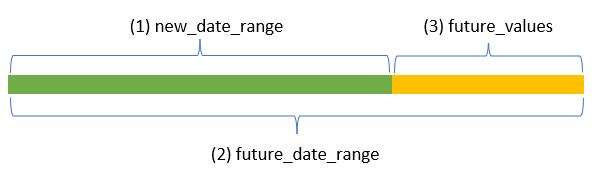


In [201]:
#General Keys
#(1) set a data range of the testing phase (2) and including tain and test
new_date_range  = pd.date_range(start="2021-01-01", end="2022-05-14", freq="D")

#(2) set a date range of start to end including the future prediction (100% of (1) for train, and predict 35 days ahead)
'''Recommendation: the end date of "new_date_range" + 35 days (prediction period) >> Check the calender'''
future_date_range =  pd.date_range(start="2021-01-01", end="2022-6-19", freq="D")

#(3) set a date range of the empty future values without existing data (The future 35 days) >> For graph
future_values = pd.date_range(start = '2022-05-15', end ='2022-06-19', freq = 'D')

In [202]:
test_days = 35     # Phase 2; 5 weeks testing with existing values
feature_futuredays = range(35)     # Phase 3: 5 weeks in the future

# **Phase 1: Data Preprocessing**

In this section, all uploaded data are cleaned to eliminate outliers or fill milling values. Please review the graphs of each tab to detect any irregular behavior in data.

# Customer Counts (y)

In [203]:
# import dataset
volume_ground = pd.read_csv('/content/drive/MyDrive/Python Dataset/demand_counts_daily.csv')
volume_ground.head()

,Date,Demand(y)
0,2019-09-02,2769.0
1,2019-09-03,2422.0
2,2019-09-04,2573.0
3,2019-09-05,2039.0
4,2019-09-06,2345.0


In [205]:
# Apply function for fearture organization and cleaning
feature_cleaning(volume_ground)

In [206]:
# Set date as index 
volume_ground.set_index('Date', inplace=True)
volume_ground = volume_ground.asfreq("D")
volume_ground.sort_values(by='Date', ascending=True).head()

,Demand(y)
Date,
2019-09-02,2769.0
2019-09-03,2422.0
2019-09-04,2573.0
2019-09-05,2039.0
2019-09-06,2345.0


In [207]:
# Review the zero values of the number of customers (business off days)
volume_ground.loc[(volume_ground['Demand(y)'] == 0)].head()

,Demand(y)
Date,
2019-12-25,0.0
2020-01-01,0.0
2020-04-12,0.0
2020-05-24,0.0
2020-05-31,0.0


In [208]:
# fill missing values 
volume_ground = volume_ground.fillna(0)

In [209]:
# #Set date range of in-sample predictions
volume_ground1 = volume_ground.reindex(new_date_range)
volume_ground1.head()

,Demand(y)
2021-01-01,0.0
2021-01-02,2529.0
2021-01-03,1446.0
2021-01-04,4227.0
2021-01-05,4420.0


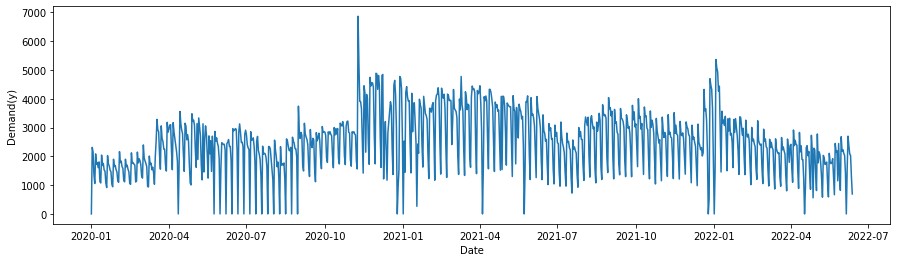

In [210]:
plt.figure(figsize=(15,4))
sns.lineplot(data = volume_ground['Demand(y)']['2020-01-01':], palette = colors)

In [211]:
# coefficient of variation

cv_dfs = [volume_ground]
cv_dfs = pd.concat(cv_dfs, join='outer', axis=1)
cols= cv_dfs.columns

# create empty list for CV
cv_list = []

# same loop but append cv_data to list each time
for column in cv_dfs.columns:
  cv_data = sp.variation(cv_dfs[column], nan_policy = 'omit')#.sort_values(ascending=False)
  cv_data = round(cv_data*100, 2)
  print("{}: {}%".format(column, cv_data))
  cv_list.append(cv_data)


# create new dataframe with column name "value" and data as cv_list
df_vnew = pd.DataFrame(cv_list, columns=['value'])

# set index names and values
df_vnew.index = [cols]
df_vnew.index.name = 'column_name'
# # print new dataframe
# print(df_new)

Demand(y): 41.85%


# Google Community Report

In [212]:
#Load csv files of the Google Communitiy Mobility Report
df_list = []
for f in sorted(gg('/content/drive/MyDrive/Python Dataset/Covid/Google_Mobility/20*_NL_*.csv')):
    df_list.append(pd.read_csv(f, sep=","))
GM_combined = pd.concat(df_list, axis=0, ignore_index=True)
GM_combined = GM_combined.drop_duplicates()

Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.


In [213]:
# rename columns and sort rows
GM_combined = GM_combined.rename(columns={'date': 'Date'})
feature_cleaning(GM_combined)
GM_combined.sort_values(by='Date', ascending=True)

# Removed unnecessary rows with zero values
GM_region_1 = GM_combined.loc[(GM_combined['place_id'] != 'ChIJu-SH28MJxkcRnwq9_851obM')]

In [214]:
#create DataFrame per sub_region_1 and groupby the date while averaging out values of each columns per day.
GM_region_1_list = list(GM_region_1['sub_region_1'].unique())
GM_region_1_dict = dict()

for region in GM_region_1_list:
    GM_region_1_dict[region] = GM_region_1.loc[(GM_region_1['sub_region_1'] == region)]

GM_region_1_dict.keys()

dict_keys(['Drenthe', 'Flevoland', 'Friesland', 'Gelderland', 'Groningen', 'Limburg', 'North Brabant', 'North Holland', 'Overijssel', 'South Holland', 'Utrecht', 'Zeeland'])

In [215]:
columns = ['retail_and_recreation_percent_change_from_baseline',
           'parks_percent_change_from_baseline'
           ]

#Create new dataframs of each region in sub_region_1
for region_name, region_df in GM_region_1_dict.items():
       #indicate the location of outcome to be saved
       save_path = f"./GM_outputs/{region_name}"

       #create df in metrics of Mean, Median, and Std.
       region_mean = region_df.groupby('Date', as_index=False, sort=True)[columns].mean()
       region_median = region_df.groupby('Date', as_index=False, sort=True)[columns].median()
       region_std = region_df.groupby('Date', as_index=False, sort=True)[columns].std()
       
       #rename the each columns with region name/metric type/column
       rename_dict = {
              'retail_and_recreation_percent_change_from_baseline': f'{region_name}_Metric_Retail_Rec_%Change', 
              'parks_percent_change_from_baseline': f'{region_name}_Metric_Park_%Change',
       }
       region_mean = region_mean.rename(columns=dict(
              map(lambda x: (x[0], x[1].replace('Metric', 'Ave')), rename_dict.items())))
       region_median = region_median.rename(columns=dict(
              map(lambda x: (x[0], x[1].replace('Metric', 'Mid')), rename_dict.items())))
       region_std = region_std.rename(columns=dict(
              map(lambda x: (x[0], x[1].replace('Metric', 'Std')), rename_dict.items())))
       
       save_columns_list = ['Date', 
                            f'{region_name}_Metric_Retail_Rec_%Change', 
                            f'{region_name}_Metric_Park_%Change'
                            ]
 
       region_mean = region_mean[list(map(lambda x: x.replace('Metric', 'Ave'), save_columns_list))].copy()
       region_median = region_median[list(map(lambda x: x.replace('Metric', 'Mid'), save_columns_list))].copy()
       region_std = region_std[list(map(lambda x: x.replace('Metric', 'Std'), save_columns_list))].copy()

       #each file is saved in the path and ready to merge with Volume
       os.makedirs(save_path, exist_ok=True)
       region_mean.to_csv(f"{save_path}/{region_name}_GM_mean.csv", index = False)
       region_median.to_csv(f"{save_path}/{region_name}_GM_median.csv", index = False)
       region_std.to_csv(f"{save_path}/{region_name}_GM_std.csv", index = False)

In [216]:
mobility = pd.DataFrame()

for f in gg('/content/GM_outputs/*/*.csv'):
    tmp = pd.read_csv(f)
    mobility = pd.concat([mobility,tmp],axis=1,ignore_index=False)

In [217]:
mobility = mobility.loc[:,~mobility.columns.duplicated()]
mobility["Date"] = pd.to_datetime(mobility["Date"])

In [218]:
#indexed the date column
mobility.set_index('Date', inplace=True)
mobility = mobility.asfreq("D")


# fill null values
mobility.fillna(method = 'ffill', inplace = True)

In [219]:
#select the date range
mobility1 = mobility.reindex(new_date_range)

# fill null values
mobility1.fillna(method = 'ffill', inplace = True)

In [220]:
#select the date range
mobility1 = mobility1.reindex(new_date_range)
mobility1.head()

,Flevoland_Mid_Retail_Rec_%Change,Flevoland_Mid_Park_%Change,Flevoland_Std_Retail_Rec_%Change,Flevoland_Std_Park_%Change,Flevoland_Ave_Retail_Rec_%Change,...,Limburg_Ave_Park_%Change,Limburg_Std_Retail_Rec_%Change,Limburg_Std_Park_%Change,Limburg_Mid_Retail_Rec_%Change,Limburg_Mid_Park_%Change
2021-01-01,-81.0,3.0,2.627691,33.049962,-82.285714,...,-20.666667,5.993661,16.231656,-79.0,-21.0
2021-01-02,-64.0,-15.0,8.847921,18.900743,-64.428571,...,-21.727273,8.400113,22.311839,-71.0,-23.0
2021-01-03,-63.0,-7.0,6.928203,19.408761,-67.000000,...,-7.600000,10.232069,23.027520,-68.0,-8.0
2021-01-04,-50.0,-19.0,6.618157,8.020806,-48.600000,...,-18.166667,5.686241,13.317908,-56.5,-20.5
2021-01-05,-53.0,4.0,5.176872,4.242641,-51.400000,...,-12.000000,5.599648,14.798649,-55.0,-19.0


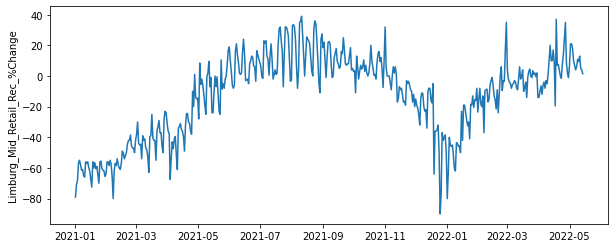

In [221]:
plt.figure(figsize=(10,4))
sns.lineplot(data = mobility1['Limburg_Mid_Retail_Rec_%Change'], palette = colors)

# Weather

In [222]:
#Load csv files from weather
df_list = []
for f in sorted(gg('/content/drive/MyDrive/Python Dataset/Weather/result*.txt')):
    df_list.append(pd.read_csv(f, skiprows=95))
weather = pd.concat(df_list, axis=0, ignore_index=True)
weather = weather.drop_duplicates()

In [223]:
#Change the datatypes
#datetime object
weather.columns = weather.columns.str.strip()
weather = weather.rename(columns={'YYYYMMDD': 'Date'})
weather["Date"] = pd.to_datetime(weather["Date"], format = "%Y%m%d")
weather.sort_values(by='Date', ascending=True)
weather = weather.drop_duplicates()

#integer to object
weather["# STN"] = weather["# STN"].astype(str)

weather = weather[['# STN', 'Date', 'DDVEC', 'FHVEC', 'FG', 'FXX',  'TG', 'TN', 'TX', 'SQ', 'NG', 'RH']].copy()

#select the features
columns = ['DDVEC', 'FHVEC', 'FG', 'FXX',  'TG', 'TN', 'TX', 'SQ', 'NG', 'RH']

#change the data types from object to float in the selected columns
weather[columns] = weather[columns].apply(pd.to_numeric, errors = 'coerce', axis = 1)
weather["RH"] = weather['RH'].apply(lambda x:0.05 if x == 0.1 else x)

In [224]:
# Remove useless stations with entirely null values
weather = weather.loc[(weather['# STN'] != '308')]
weather = weather.loc[(weather['# STN'] != '313')]
weather = weather.loc[(weather['# STN'] != '331')]

In [225]:
#group by per day
#take median of each station
weather = weather.groupby('Date', as_index=True, sort=True)[columns].median()

In [226]:
# fill null values with the values from the one before
weather.fillna(method = 'ffill', inplace = True)

In [227]:
# Set the date range
weather1 = weather.reindex(new_date_range)

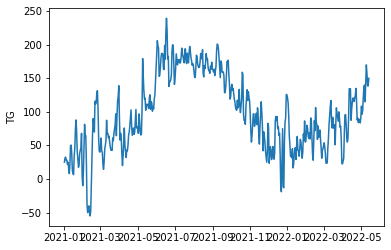

In [228]:
sns.lineplot(data = weather1['TG'], palette = 'g')

# Holiday

In [229]:
holi = pd.read_excel('/content/drive/MyDrive/Python Dataset/Holiday/Holidays.xlsx')
holi = holi.drop_duplicates()

In [230]:
feature_cleaning(holi)

In [231]:
#fill non sales dates with zero
holi = holi.fillna(0)
holi.isnull().sum()

#Set the Sales_Offered as binary
holi['Holidays'] = holi['Holidays'].astype('bool')
holi['christmas_NY'] = holi['christmas_NY'].astype('bool')
holi['easter_whit'] = holi['easter_whit'].astype('bool')

#One Hot Encoding on the day of the week
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(holi[['Day_of_Week']]).toarray())
holi = holi.join(encoder_df)

#indexed the date column
holi.set_index('Date', inplace=True)
holi = holi.asfreq("D")

In [232]:
holi = holi.rename(columns={0: 'Fri',
                                    1: 'Mon',
                                    2: 'Sat',
                                    3: 'Sun',
                                    4: 'Thu',
                                    5: 'Tue',
                                    6: 'Wed'                             
})

In [233]:
# select the change orders of features
holi = holi[['Holidays', 'christmas_NY', 'easter_whit', 
      'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', ]]

In [234]:
#Set date range
holi1 = holi.reindex(new_date_range)
holi1.tail()

,Holidays,christmas_NY,easter_whit,Mon,Tue,Wed,Thu,Fri,Sat,Sun
2022-05-10,False,False,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-05-11,False,False,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2022-05-12,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-05-13,False,False,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-05-14,False,False,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0


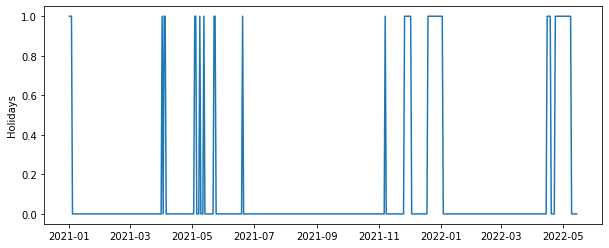

In [235]:
plt.figure(figsize=(10,4))
sns.lineplot(data = holi1['Holidays'], palette = colors)

# Covid Stringency Index

In [236]:
#Load csv files
df_list = []
for f in sorted(gg('/content/drive/MyDrive/Python Dataset/Covid/Stringency_Index/owid-covid*.csv')):
    df_list.append(pd.read_csv(f, sep=","))
stringency = pd.concat(df_list, axis=0, ignore_index=True)
stringency = stringency.drop_duplicates()

In [237]:
stringency.head()

,iso_code,continent,location,date,total_cases,...,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,...,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,...,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,...,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,...,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,...,0.511,NaN,NaN,NaN,NaN


In [238]:
# select Netherlands data, select necessary columns and change data types
stringency = stringency.rename(columns={'date': 'Date'})
NL_Stringency = stringency.loc[(stringency['location'] == 'Netherlands')]
NL_Stringency = NL_Stringency[['Date', 'stringency_index', 'new_cases_smoothed',
                               'new_deaths_smoothed',
                               ]]

NL_Stringency["Date"] = pd.to_datetime(NL_Stringency["Date"])
NL_Stringency.sort_values(by='Date', ascending=True)
NL_Stringency = NL_Stringency.drop_duplicates()
NL_Stringency.fillna(method = 'ffill', inplace = True)

# set date index
NL_Stringency.set_index('Date', inplace=True)
NL_Stringency = NL_Stringency.asfreq("D")

# set date range
NL_Stringency1 = NL_Stringency.reindex(new_date_range)

In [239]:
NL_Stringency.columns

Index(['stringency_index', 'new_cases_smoothed', 'new_deaths_smoothed'], dtype='object')

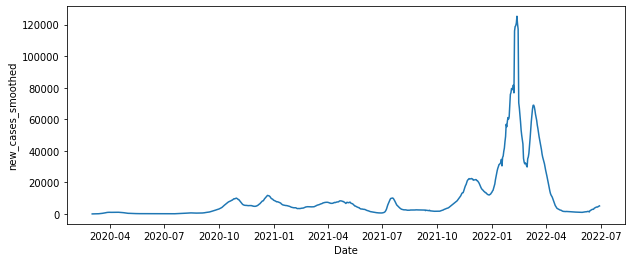

In [240]:
plt.figure(figsize=(10,4))
sns.lineplot(data = NL_Stringency['new_cases_smoothed'], palette = colors)

In [241]:
NL_Stringency1.tail()

,stringency_index,new_cases_smoothed,new_deaths_smoothed
2022-05-10,19.44,1434.143,2.714
2022-05-11,19.44,1393.429,3.000
2022-05-12,19.44,1359.000,3.286
2022-05-13,19.44,1353.429,3.143
2022-05-14,19.44,1331.286,2.857


# In-Sample Dataset

In this section, all dataframes are going to be merged.

In [242]:
from functools import reduce
import pandas as pd

# concat the dataframes 
dfs = [volume_ground1, mobility1, weather1, holi1,
       NL_Stringency1
       ] 

all = pd.concat(dfs, join='outer', axis=1)

In [243]:
all.columns.nunique()

96

In [244]:
# fill the possible null values with the one value before
all.fillna(method = 'ffill', inplace = True)

# Out-of-Sample Dataset

---
**Coefficient of Variation (CV)**\
It is a ratio of the standard deviation to the mean. In other words, it evaluates how much variance the dataset has shown in percentage. The higher the value, the higher the variance.
The calculation is Standard Deviation/ Mean. If CV > 1, it indicates a relatively high variation of data, while CV < 1 means less variance. This statistical analysis is benefitial to evaluate which features can be useful to include in the out-of-sample forecasting. It is because even if all features improved the accuracy in in-sample, it doesn't mean it is helpful also for the out-of-sample. Standard Deviation is a common measure of variability, and it is simply the square roof of the variance. However, since it uses the same unit as the original data, it is difficult to use for the feature evaluation since they have different units.







```
CV = 100*Std/Mean
```
---


In [245]:
# select non-plnannable features
cv_dfs = [mobility, NL_Stringency, weather]
cv_dfs = pd.concat(cv_dfs, join='outer', axis=1)

In [246]:
cv_dfs.head()

,Flevoland_Mid_Retail_Rec_%Change,Flevoland_Mid_Park_%Change,Flevoland_Std_Retail_Rec_%Change,Flevoland_Std_Park_%Change,Flevoland_Ave_Retail_Rec_%Change,...,TN,TX,SQ,NG,RH
Date,,,,,,,,,,,
2019-09-02,NaN,NaN,NaN,NaN,NaN,...,94.0,201.5,93.5,5.0,0.0
2019-09-03,NaN,NaN,NaN,NaN,NaN,...,132.0,201.5,16.0,7.0,0.0
2019-09-04,NaN,NaN,NaN,NaN,NaN,...,117.5,189.0,25.5,6.0,55.0
2019-09-05,NaN,NaN,NaN,NaN,NaN,...,75.5,171.5,65.5,5.0,17.0
2019-09-06,NaN,NaN,NaN,NaN,NaN,...,78.0,186.0,26.5,7.0,26.0


In [247]:
# create empty list for CV
cols= cv_dfs.columns
cv_list = []

# same loop but append cv_data to list each time
for column in cv_dfs.columns:
  cv_data = sp.variation(cv_dfs[column], nan_policy = 'omit')#.sort_values(ascending=False)
  cv_data = round(cv_data*100, 2)
  print("{}: {}%".format(column, cv_data))
  cv_list.append(cv_data)


# create new dataframe with column name "value" and data as cv_list
df_new = pd.DataFrame(cv_list, columns=['value'])

# set index names and values
df_new.index = [cols]
df_new.index.name = 'column_name'

Flevoland_Mid_Retail_Rec_%Change: -163.99%
Flevoland_Mid_Park_%Change: 105.59%
Flevoland_Std_Retail_Rec_%Change: 81.55%
Flevoland_Std_Park_%Change: 91.39%
Flevoland_Ave_Retail_Rec_%Change: -197.99%
Flevoland_Ave_Park_%Change: 110.15%
Gelderland_Std_Retail_Rec_%Change: 45.13%
Gelderland_Std_Park_%Change: 44.04%
Gelderland_Mid_Retail_Rec_%Change: -271.77%
Gelderland_Mid_Park_%Change: 101.3%
Gelderland_Ave_Retail_Rec_%Change: -290.08%
Gelderland_Ave_Park_%Change: 100.61%
Drenthe_Mid_Retail_Rec_%Change: -218.56%
Drenthe_Mid_Park_%Change: 118.03%
Drenthe_Ave_Retail_Rec_%Change: -248.98%
Drenthe_Ave_Park_%Change: 117.85%
Drenthe_Std_Retail_Rec_%Change: 56.61%
Drenthe_Std_Park_%Change: 72.51%
Overijssel_Ave_Retail_Rec_%Change: -233.06%
Overijssel_Ave_Park_%Change: 96.68%
Overijssel_Mid_Retail_Rec_%Change: -162.54%
Overijssel_Mid_Park_%Change: 96.82%
Overijssel_Std_Retail_Rec_%Change: 73.03%
Overijssel_Std_Park_%Change: 96.35%
South Holland_Std_Retail_Rec_%Change: 36.5%
South Holland_Std_Park_

In [248]:
df_new = df_new.reset_index()
good_cvs = df_new.loc[(df_new['value'] <80 ) & (df_new['value'] > 0)]

In [249]:
# Get a list of features that are fit within the good cv range to include in the out-of-sample models
feature_list = good_cvs['level_0'].values.tolist()
feature_list

['Gelderland_Std_Retail_Rec_%Change',
 'Gelderland_Std_Park_%Change',
 'Drenthe_Std_Retail_Rec_%Change',
 'Drenthe_Std_Park_%Change',
 'Overijssel_Std_Retail_Rec_%Change',
 'South Holland_Std_Retail_Rec_%Change',
 'South Holland_Std_Park_%Change',
 'Utrecht_Std_Retail_Rec_%Change',
 'Utrecht_Std_Park_%Change',
 'Groningen_Std_Retail_Rec_%Change',
 'North Brabant_Std_Retail_Rec_%Change',
 'North Brabant_Std_Park_%Change',
 'Friesland_Std_Retail_Rec_%Change',
 'Zeeland_Std_Retail_Rec_%Change',
 'North Holland_Std_Retail_Rec_%Change',
 'North Holland_Std_Park_%Change',
 'Limburg_Std_Retail_Rec_%Change',
 'Limburg_Std_Park_%Change',
 'stringency_index',
 'DDVEC',
 'FHVEC',
 'FG',
 'FXX',
 'TG',
 'TN',
 'TX',
 'NG']

Impute the future values and set the required date range

In [250]:
# Fill the future values of non-plannable features

'''Movig Average of the same day of the week from the past 30 days'''
# Covid-19 Stringency Index
mean_of_day_of_the_week_from_past_30days(NL_Stringency)
NL_Stringency2 = NL_Stringency

# Google Community Mobility Report
mean_of_day_of_the_week_from_past_30days(mobility)
mobility2 = mobility

''' Taking Mean Value of Past 2 Years '''
past_years_future_valuesues(weather)
weather2 = weather.reindex(future_date_range)

''' No Need to Add Future Values '''
holi2 = holi.reindex(future_date_range)


Mergining all dataset of the imputated features

In [251]:
dfs_clean = [ weather2, holi2,
              NL_Stringency2, mobility2]

# Concat the imputed independent variables
dfs_clean = pd.concat(dfs_clean, join='outer', axis=1)
dfs_clean = dfs_clean.reindex(future_date_range)

dfs_clean.fillna(method = 'ffill', inplace = True)

Concat the independent variables with the dependent variable for the out-of-sample forecasting

In [252]:
dfs_future = [volume_ground1, dfs_clean]


# solution 1 (fast)
all_future = pd.concat(dfs_future, join='outer', axis=1)
all_future = all_future.reindex(future_date_range)

In [253]:
all_future.head()

,Demand(y),DDVEC,FHVEC,FG,FXX,...,Limburg_Ave_Park_%Change,Limburg_Std_Retail_Rec_%Change,Limburg_Std_Park_%Change,Limburg_Mid_Retail_Rec_%Change,Limburg_Mid_Park_%Change
2021-01-01,0.0,231.0,25.0,28.0,60.0,...,-20.666667,5.993661,16.231656,-79.0,-21.0
2021-01-02,2529.0,203.0,15.0,22.0,60.0,...,-21.727273,8.400113,22.311839,-71.0,-23.0
2021-01-03,1446.0,47.0,47.0,48.0,110.0,...,-7.600000,10.232069,23.027520,-68.0,-8.0
2021-01-04,4227.0,47.0,71.0,72.0,130.0,...,-18.166667,5.686241,13.317908,-56.5,-20.5
2021-01-05,4420.0,51.0,56.0,56.0,110.0,...,-12.000000,5.599648,14.798649,-55.0,-19.0


In [254]:
# make sure that all expected features are included
all_future.columns.to_list()

['Demand(y)',
 'DDVEC',
 'FHVEC',
 'FG',
 'FXX',
 'TG',
 'TN',
 'TX',
 'SQ',
 'NG',
 'RH',
 'Holidays',
 'christmas_NY',
 'easter_whit',
 'Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Sun',
 'stringency_index',
 'new_cases_smoothed',
 'new_deaths_smoothed',
 'Flevoland_Mid_Retail_Rec_%Change',
 'Flevoland_Mid_Park_%Change',
 'Flevoland_Std_Retail_Rec_%Change',
 'Flevoland_Std_Park_%Change',
 'Flevoland_Ave_Retail_Rec_%Change',
 'Flevoland_Ave_Park_%Change',
 'Gelderland_Std_Retail_Rec_%Change',
 'Gelderland_Std_Park_%Change',
 'Gelderland_Mid_Retail_Rec_%Change',
 'Gelderland_Mid_Park_%Change',
 'Gelderland_Ave_Retail_Rec_%Change',
 'Gelderland_Ave_Park_%Change',
 'Drenthe_Mid_Retail_Rec_%Change',
 'Drenthe_Mid_Park_%Change',
 'Drenthe_Ave_Retail_Rec_%Change',
 'Drenthe_Ave_Park_%Change',
 'Drenthe_Std_Retail_Rec_%Change',
 'Drenthe_Std_Park_%Change',
 'Overijssel_Ave_Retail_Rec_%Change',
 'Overijssel_Ave_Park_%Change',
 'Overijssel_Mid_Retail_Rec_%Change',
 'Overijssel_Mid_Park_%Ch

Plot one of the independent features with the imputed values shown in red

In [255]:
all_future_graph = all_future.reindex(future_values)

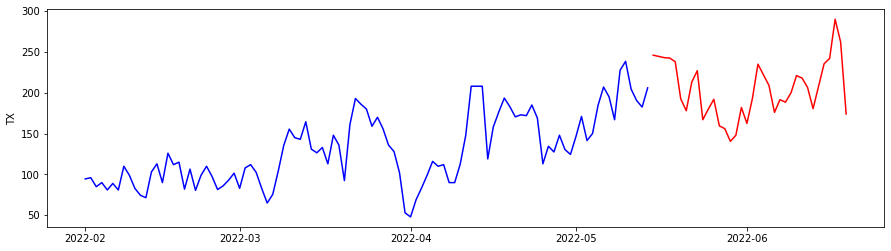

In [256]:
plt.figure(figsize=(15,4))
sns.lineplot(data = all_future_graph['TX']['2022-02-01':], color = 'r')
sns.lineplot(data = all['TX']['2022-02-01':], color = 'b')

#Residual Check

Sales Performance Residuals 

In [257]:
# # get the feature of the actual and future values
# residual_future = all_future_graph['TX']
# residual_now = all['TX']
# residual = [residual_now, residual_future]
# residuals = pd.concat(residual, join='outer', axis=1)
# residuals.columns = ['actual', 'future']
# residuals.tail()

In [258]:
# # fit simple linear regression model
# linear_model = ols('actual ~ future',
#                    data=residuals).fit()
  
# # display model summary
# print(linear_model.summary())
  
# # modify figure size
# fig = plt.figure(figsize=(14, 8))
  
# # creating regression plots
# fig = sm.graphics.plot_regress_exog(linear_model,
#                                     'future',
#                                     fig=fig)

# Correlation

In [259]:
all.corr()

,Demand(y),Flevoland_Mid_Retail_Rec_%Change,Flevoland_Mid_Park_%Change,Flevoland_Std_Retail_Rec_%Change,Flevoland_Std_Park_%Change,...,Sat,Sun,stringency_index,new_cases_smoothed,new_deaths_smoothed
Demand(y),1.000000,-0.163470,-0.061492,-0.415846,-0.240370,...,-0.308997,-0.595240,0.420003,-0.125925,0.199330
Flevoland_Mid_Retail_Rec_%Change,-0.163470,1.000000,0.584368,0.415907,0.103838,...,-0.039196,-0.080777,-0.721210,-0.085987,-0.744285
Flevoland_Mid_Park_%Change,-0.061492,0.584368,1.000000,0.349221,0.340936,...,-0.070631,-0.033509,-0.230058,-0.379842,-0.452686
Flevoland_Std_Retail_Rec_%Change,-0.415846,0.415907,0.349221,1.000000,0.469966,...,0.060373,0.332610,-0.320365,-0.153866,-0.317669
Flevoland_Std_Park_%Change,-0.240370,0.103838,0.340936,0.469966,1.000000,...,0.187082,0.207998,0.022192,-0.173345,-0.037408
...,...,...,...,...,...,...,...,...,...,...,...
Sat,-0.308997,-0.039196,-0.070631,0.060373,0.187082,...,1.000000,-0.167247,-0.002958,-0.002020,0.001931
Sun,-0.595240,-0.080777,-0.033509,0.332610,0.207998,...,-0.167247,1.000000,0.009615,0.001312,0.005853
stringency_index,0.420003,-0.721210,-0.230058,-0.320365,0.022192,...,-0.002958,0.009615,1.000000,-0.111100,0.621781
new_cases_smoothed,-0.125925,-0.085987,-0.379842,-0.153866,-0.173345,...,-0.002020,0.001312,-0.111100,1.000000,-0.113968


In [260]:
pd.set_option('display.max_rows', None)
correlation = all[all.columns[0:]].corr()['Demand(y)'][:-1].round(3).abs().sort_values(ascending=False)
correlation.head(30)

Demand(y)                               1.000
Sun                                     0.595
stringency_index                        0.420
Flevoland_Std_Retail_Rec_%Change        0.416
Overijssel_Std_Retail_Rec_%Change       0.405
Gelderland_Std_Retail_Rec_%Change       0.384
South Holland_Std_Retail_Rec_%Change    0.365
North Holland_Std_Retail_Rec_%Change    0.361
North Holland_Std_Park_%Change          0.346
Utrecht_Std_Park_%Change                0.329
Groningen_Std_Park_%Change              0.327
Limburg_Std_Retail_Rec_%Change          0.323
Drenthe_Std_Retail_Rec_%Change          0.321
Sat                                     0.309
Mon                                     0.295
Zeeland_Std_Retail_Rec_%Change          0.295
Utrecht_Std_Retail_Rec_%Change          0.286
Groningen_Std_Retail_Rec_%Change        0.267
Friesland_Std_Retail_Rec_%Change        0.258
Flevoland_Std_Park_%Change              0.240
Gelderland_Std_Park_%Change             0.240
North Brabant_Std_Retail_Rec_%Chan

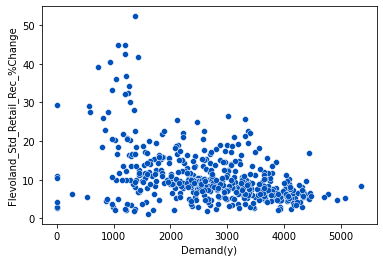

In [261]:
sns.scatterplot(data=all, x="Demand(y)", y="Flevoland_Std_Retail_Rec_%Change", color = '#0051BA')
pd.set_option('display.max_rows', 10)

#Stationarity

In [262]:
Augmented_Dickey_Fuller_Test_func(all['Demand(y)'],'Demand(y)')

Results of Dickey-Fuller Test for column: Demand(y)
Test Statistic                  -1.411444
p-value                          0.576778
No Lags Used                    14.000000
Number of Observations Used    484.000000
Critical Value (1%)             -3.443933
Critical Value (5%)             -2.867530
Critical Value (10%)            -2.569961
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


# Data Distribution Check

QQ plot (quantile-quantile plot)
* Is this data normally distributed? 
 * normal quantiles vs uniform quantiles to find better fit


* Goodness of fit to a distribution: The Chi-squared test can be used to determine whether your data obeys a known theoretical probability distribution such as the Normal or Poisson distribution.

* Goodness of fit of a regression model: The Chi-squared test can be used to measure the goodness-of-fit of your trained regression model on the training, validation, or test data sets.

* Minimum Chi-squared estimation: For data sets that obey parametric distributions such as the Normal, Poisson or Binomial distributions, the the Chi-squared test can be used to find the parameter range over which the observed values will obey the theoretical distribution.

* Test for independence: The Chi-squared test can be used to test whether two categorical random variables such as Age and Income whose values have been measured in an experiment, are independent of each other.


In [263]:
# QQ plot import
#from scipy.stats import chisquare
from scipy.special import ndtri

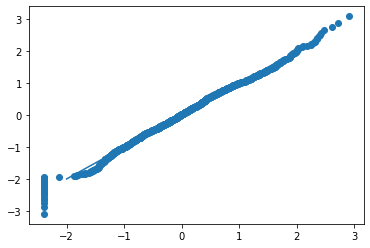

In [264]:
dist_check = volume_ground.sort_values(by=['Demand(y)'], ascending = True).reset_index()
#Divide the standard normal distribution that is the theoritical distribution into n+1 = n
dist_check['count'] = dist_check.index+1
n_rows = dist_check.shape[0]
dist_check['percentile_area'] = (dist_check['count'])/n_rows
dist_check['z_theoritical'] = ndtri(dist_check['percentile_area'])
dist_check['z_actual']  = (dist_check['Demand(y)'] - dist_check['Demand(y)'].mean())/dist_check['Demand(y)'].std(ddof = 0)

plt.scatter(dist_check.z_actual, dist_check.z_theoritical)
plt.plot([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])
plt.show()

In [265]:
dist_check.loc[(dist_check['z_actual'] < -2.3)]

,Date,Demand(y),count,percentile_area,z_theoritical,z_actual
0,2020-07-26,0.0,1,0.000985,-3.094651,-2.389451
1,2020-01-01,0.0,2,0.001970,-2.882855,-2.389451
2,2020-04-12,0.0,3,0.002956,-2.752660,-2.389451
3,2020-05-24,0.0,4,0.003941,-2.657093,-2.389451
4,2020-05-31,0.0,5,0.004926,-2.580973,-2.389451
...,...,...,...,...,...,...
21,2022-04-17,0.0,22,0.021675,-2.020324,-2.389451
22,2020-08-30,0.0,23,0.022660,-2.001670,-2.389451
23,2020-08-23,0.0,24,0.023645,-1.983688,-2.389451
24,2021-01-01,0.0,25,0.024631,-1.966325,-2.389451


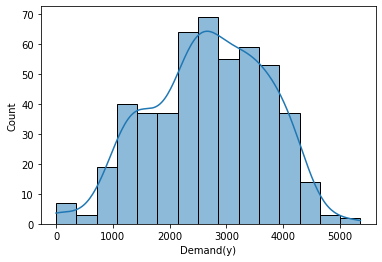

In [266]:
# Histogram of data distribution
sns.histplot(data = all, x ='Demand(y)', kde = True)
plt.show()

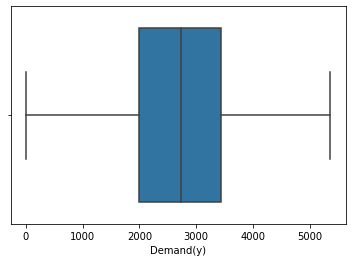

In [267]:
sns.boxplot(data = all, x ='Demand(y)')

Actual and theoritical distribution check. Not all points fall on the y=x line. So the data isn't completely distributed.

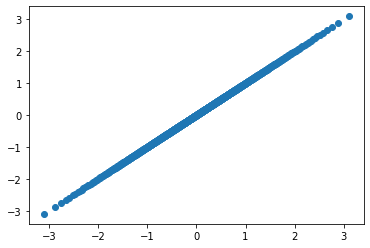

In [268]:
# This is how it should look like.
plt.scatter(dist_check.z_theoritical, dist_check.z_theoritical)
plt.plot([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

#**Phase 2: Testing Models**

In this section, Prophet, Prophet+XGB, and Ensembled models are applied for the forecasting. 
1. Apply the organized data into models
2. Run the models
3. Get the assessment scores


# Prep: "Dataset" and "Holidays"

In [269]:
# bring the date index into column
dataset = all.reset_index()
dataset['Date'] = dataset["index"].dt.strftime('%Y-%m-%d')

In [270]:
# Data Transformation
dataset.Date = pd.to_datetime(dataset.Date, format = '%Y-%m-%d')
dataset.Date

0     2021-01-01
1     2021-01-02
2     2021-01-03
3     2021-01-04
4     2021-01-05
         ...    
494   2022-05-10
495   2022-05-11
496   2022-05-12
497   2022-05-13
498   2022-05-14
Name: Date, Length: 499, dtype: datetime64[ns]

In [271]:
# Due to the requirement of FBProphet, rename y column and datastamp variables
dataset = dataset.rename(columns= {'Demand(y)':'y'})
dataset = dataset.rename(columns= {'Date':'ds'})


In [272]:
#Holidays
"""""""""""""""""""""""""""""""""""""""
Store holiday dates from the Holidays column
---------------------------------------
In case of Facebook Prophet, holiday data could be simpler as it couls set up
the date range to consider as holidays.
However, it can't specify more details of holiday range. For example, christmas 
holidays can last two weeks while black friday or other national holidays can be less.

If I would like to specify each of the holidays range differently, I would need 
to create each one of these per holiday 
"""""""""""""""""""""""""""""""""""""""
holiday_dates = dataset[dataset.Holidays == 1].ds
holidays = pd.DataFrame({'holiday': 'holi', 
                         'ds':pd.to_datetime(holiday_dates),
                         #'lower_window':0, #3 days prior to the holiday that was counted
                         #'upper_window':0  
                         #1 day after to the holiday that was counted
})                       #upper and lower can be 0 as they are manually specified
holidays.head()

,holiday,ds
0,holi,2021-01-01
1,holi,2021-01-02
2,holi,2021-01-03
91,holi,2021-04-02
93,holi,2021-04-04


In [273]:
#remove Holidays columns from dataset as the holidays are created seperately.
dataset = dataset.drop(columns = "Holidays")
dataset = dataset.fillna(0)
dataset.head(2)


,index,y,Flevoland_Mid_Retail_Rec_%Change,Flevoland_Mid_Park_%Change,Flevoland_Std_Retail_Rec_%Change,...,Sun,stringency_index,new_cases_smoothed,new_deaths_smoothed,ds
0,2021-01-01,0.0,-81.0,3.0,2.627691,...,0.0,78.7,8560.714,86.571,2021-01-01
1,2021-01-02,2529.0,-64.0,-15.0,8.847921,...,0.0,78.7,8321.000,85.143,2021-01-02


In [274]:
test_set = dataset.iloc[-test_days:, :]
actual_value = test_set['y']

In [275]:
actual_value

464     885.0
465    2829.0
466    2157.0
467    2364.0
468    1891.0
        ...  
494    1957.0
495    1717.0
496    1746.0
497    1800.0
498    1069.0
Name: y, Length: 35, dtype: float64

# Model 1: Prophet



**Benefit of Prophet Model**\
(+) dynamic holidays; it allows us to further dig and study about holidays\
(+) customizable and intuitive for non-experts; built-in cross validation and hyperparameter tuning\


**Methodological framework**\
y(t) = c(t)+s(t)+h(t)+x(t)+e

where c(t) = trent, s(t) = seasonality, and h(t) = holiday effects, x(t) = external variables/regressors, and e = error

In [276]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Seperating the dataset into Training and Testing
"""""""""""""""""""""""""""""""""""""""""""""""""""
prophet_training_set = dataset.iloc[:-test_days, :]
prophet_test_set = dataset.iloc[-test_days:, :]
prophet_test_set

,index,y,Flevoland_Mid_Retail_Rec_%Change,Flevoland_Mid_Park_%Change,Flevoland_Std_Retail_Rec_%Change,...,Sun,stringency_index,new_cases_smoothed,new_deaths_smoothed,ds
464,2022-04-10,885.0,7.0,57.5,5.033223,...,1.0,23.15,11241.857,12.143,2022-04-10
465,2022-04-11,2829.0,-2.0,49.5,7.918333,...,0.0,23.15,10650.857,11.143,2022-04-11
466,2022-04-12,2157.0,-1.0,90.0,9.230385,...,0.0,23.15,9546.429,11.286,2022-04-12
467,2022-04-13,2364.0,-3.0,69.5,3.741657,...,0.0,23.15,8389.714,11.429,2022-04-13
468,2022-04-14,1891.0,-2.0,84.5,9.093954,...,0.0,23.15,7220.286,11.571,2022-04-14
...,...,...,...,...,...,...,...,...,...,...,...
494,2022-05-10,1957.0,-4.0,125.0,9.300538,...,0.0,19.44,1434.143,2.714,2022-05-10
495,2022-05-11,1717.0,-3.0,114.0,6.324555,...,0.0,19.44,1393.429,3.000,2022-05-11
496,2022-05-12,1746.0,-3.0,110.0,9.576012,...,0.0,19.44,1359.000,3.286,2022-05-12
497,2022-05-13,1800.0,1.0,125.0,15.845083,...,0.0,19.44,1353.429,3.143,2022-05-13


In [277]:
#check
stats_labels = ['Mean Demand(y)', 'Variance Demand(y)', 'Minimum Demand(y)', 'Maximum Demand(y)']
stats_values = [round(prophet_training_set['y'].mean(), 2), round(prophet_training_set['y'].var(), 2), prophet_training_set['y'].min(), prophet_training_set['y'].max()]
print('Statistical Summary of Training Dependent Variable (y)')
print(set(zip(stats_labels, stats_values)))

#check
stats_labels = ['Mean Demand(y)', 'Variance Demand(y)', 'Minimum Demand(y)', 'Maximum Demand(y)']
stats_values = [round(prophet_test_set['y'].mean(), 2), round(prophet_test_set['y'].var(), 2), prophet_test_set['y'].min(), prophet_test_set['y'].max()]
print('Statistical Summary of Test Dependent Variable (y)')
print(set(zip(stats_labels, stats_values)))

Statistical Summary of Training Dependent Variable (y)
{('Maximum Demand(y)', 5362.0), ('Mean Demand(y)', 2760.47), ('Minimum Demand(y)', 0.0), ('Variance Demand(y)', 995086.61)}
Statistical Summary of Test Dependent Variable (y)
{('Maximum Demand(y)', 2829.0), ('Minimum Demand(y)', 0.0), ('Mean Demand(y)', 1716.6), ('Variance Demand(y)', 471894.13)}


**Facebook Prophet Component Descriptions**


*   **Growth** : Linear / Logistic ; how does the trend shape like?
*   **Holidays**: use the one prepared already above
*   **Seasonality**: yearly, weekly, daily
*   **Seasonality_mode**: multiplicative or additive
*   **Seasonality_Prior_scale**: strength of the seasonality (continous number). higher number means stronger seasonality
*   **Holiday_Prior_scale**: strength of the holiday (continous number)
*   **Changepoint_prior_scale**: flexibility of the automatic changepoint selection: how to detect the changes in trend and whether it should detect changes in trend easily or more robust




In [278]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Facebook Prophet Model
"""""""""""""""""""""""""""""""""""""""""""""""""""
m = Prophet(growth = 'linear',
            yearly_seasonality=True, #Jan to Feb etc
            weekly_seasonality=True, #monday to sunday seasonality
            daily_seasonality= True, #if data is daily, then True
            holidays = holidays, #it was already defined earlier
            seasonality_mode ='additive', #use additive seasonality during the pandemic so that it’s not biased by 2020’s abnormal baseline, especially when COVID greatly impacts your time series data.
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05 #this is more to leave it to the model and reflect how easy it is to have a break of trends
            )

m.add_regressor('DDVEC')
m.add_regressor('FHVEC')
m.add_regressor('FG')
m.add_regressor('FXX')
m.add_regressor('TG')
m.add_regressor('TN')
m.add_regressor('TX')
m.add_regressor('SQ')
m.add_regressor('NG')
m.add_regressor('RH')
m.add_regressor('christmas_NY')
m.add_regressor('easter_whit')
m.add_regressor('Mon')
m.add_regressor('Tue')
m.add_regressor('Wed')
m.add_regressor('Thu')
m.add_regressor('Fri')
m.add_regressor('Sat')
m.add_regressor('Sun')
m.add_regressor('stringency_index')
m.add_regressor('new_cases_smoothed')
m.add_regressor('new_deaths_smoothed')
m.add_regressor('Drenthe_Ave_Retail_Rec_%Change')
m.add_regressor('Drenthe_Ave_Park_%Change')
m.add_regressor('Drenthe_Std_Retail_Rec_%Change')
m.add_regressor('Drenthe_Std_Park_%Change')
m.add_regressor('Drenthe_Mid_Retail_Rec_%Change')
m.add_regressor('Drenthe_Mid_Park_%Change')
m.add_regressor('Groningen_Mid_Retail_Rec_%Change')
m.add_regressor('Groningen_Mid_Park_%Change')
m.add_regressor('Groningen_Ave_Retail_Rec_%Change')
m.add_regressor('Groningen_Ave_Park_%Change')
m.add_regressor('Groningen_Std_Retail_Rec_%Change')
m.add_regressor('Groningen_Std_Park_%Change')
m.add_regressor('Zeeland_Std_Retail_Rec_%Change')
m.add_regressor('Zeeland_Std_Park_%Change')
m.add_regressor('Zeeland_Mid_Retail_Rec_%Change')
m.add_regressor('Zeeland_Mid_Park_%Change')
m.add_regressor('Zeeland_Ave_Retail_Rec_%Change')
m.add_regressor('Zeeland_Ave_Park_%Change')
m.add_regressor('Flevoland_Ave_Retail_Rec_%Change')
m.add_regressor('Flevoland_Ave_Park_%Change')
m.add_regressor('Flevoland_Mid_Retail_Rec_%Change')
m.add_regressor('Flevoland_Mid_Park_%Change')
m.add_regressor('Flevoland_Std_Retail_Rec_%Change')
m.add_regressor('Flevoland_Std_Park_%Change')
m.add_regressor('South Holland_Std_Retail_Rec_%Change')
m.add_regressor('South Holland_Std_Park_%Change')
m.add_regressor('South Holland_Ave_Retail_Rec_%Change')
m.add_regressor('South Holland_Ave_Park_%Change')
m.add_regressor('South Holland_Mid_Retail_Rec_%Change')
m.add_regressor('South Holland_Mid_Park_%Change')
m.add_regressor('North Brabant_Ave_Retail_Rec_%Change')
m.add_regressor('North Brabant_Ave_Park_%Change')
m.add_regressor('North Brabant_Std_Retail_Rec_%Change')
m.add_regressor('North Brabant_Std_Park_%Change')
m.add_regressor('North Brabant_Mid_Retail_Rec_%Change')
m.add_regressor('North Brabant_Mid_Park_%Change')
m.add_regressor('Friesland_Std_Retail_Rec_%Change')
m.add_regressor('Friesland_Std_Park_%Change')
m.add_regressor('Friesland_Mid_Retail_Rec_%Change')
m.add_regressor('Friesland_Mid_Park_%Change')
m.add_regressor('Friesland_Ave_Retail_Rec_%Change')
m.add_regressor('Friesland_Ave_Park_%Change')
m.add_regressor('Gelderland_Mid_Retail_Rec_%Change')
m.add_regressor('Gelderland_Mid_Park_%Change')
m.add_regressor('Gelderland_Ave_Retail_Rec_%Change')
m.add_regressor('Gelderland_Ave_Park_%Change')
m.add_regressor('Gelderland_Std_Retail_Rec_%Change')
m.add_regressor('Gelderland_Std_Park_%Change')
m.add_regressor('Utrecht_Ave_Retail_Rec_%Change')
m.add_regressor('Utrecht_Ave_Park_%Change')
m.add_regressor('Utrecht_Mid_Retail_Rec_%Change')
m.add_regressor('Utrecht_Mid_Park_%Change')
m.add_regressor('Utrecht_Std_Retail_Rec_%Change')
m.add_regressor('Utrecht_Std_Park_%Change')
m.add_regressor('Limburg_Mid_Retail_Rec_%Change')
m.add_regressor('Limburg_Mid_Park_%Change')
m.add_regressor('Limburg_Std_Retail_Rec_%Change')
m.add_regressor('Limburg_Std_Park_%Change')
m.add_regressor('Limburg_Ave_Retail_Rec_%Change')
m.add_regressor('Limburg_Ave_Park_%Change')
m.add_regressor('North Holland_Std_Retail_Rec_%Change')
m.add_regressor('North Holland_Std_Park_%Change')
m.add_regressor('North Holland_Mid_Retail_Rec_%Change')
m.add_regressor('North Holland_Mid_Park_%Change')
m.add_regressor('North Holland_Ave_Retail_Rec_%Change')
m.add_regressor('North Holland_Ave_Park_%Change')
m.add_regressor('Overijssel_Std_Retail_Rec_%Change')
m.add_regressor('Overijssel_Std_Park_%Change')
m.add_regressor('Overijssel_Ave_Retail_Rec_%Change')
m.add_regressor('Overijssel_Ave_Park_%Change')
m.add_regressor('Overijssel_Mid_Retail_Rec_%Change')
m.add_regressor('Overijssel_Mid_Park_%Change')




m.fit(prophet_training_set)

In [279]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Forecasting
"""""""""""""""""""""""""""""""""""""""""""""""""""
# Create Future Dataframe
future = m.make_future_dataframe(periods = len(prophet_test_set),
                                 freq = "D")
future.tail(1)

,ds
498,2022-05-14


In [280]:
# merge regressors
future = pd.concat([future, dataset.iloc[:, 1:-1]], # do not include "ds" and 'y' columns
                    axis = 1)


In [281]:
future.head()

,ds,y,Flevoland_Mid_Retail_Rec_%Change,Flevoland_Mid_Park_%Change,Flevoland_Std_Retail_Rec_%Change,...,Sat,Sun,stringency_index,new_cases_smoothed,new_deaths_smoothed
0,2021-01-01,0.0,-81.0,3.0,2.627691,...,0.0,0.0,78.7,8560.714,86.571
1,2021-01-02,2529.0,-64.0,-15.0,8.847921,...,1.0,0.0,78.7,8321.000,85.143
2,2021-01-03,1446.0,-63.0,-7.0,6.928203,...,0.0,1.0,78.7,8199.286,87.857
3,2021-01-04,4227.0,-50.0,-19.0,6.618157,...,0.0,0.0,78.7,8030.857,90.429
4,2021-01-05,4420.0,-53.0,4.0,5.176872,...,0.0,0.0,78.7,7706.286,92.857


In [282]:
#Forecasting
forecast = m.predict(future)

In [283]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Prediction
"""""""""""""""""""""""""""""""""""""""""""""""""""
predictions_prophet = forecast.yhat[-test_days:].rename('prophet')
predictions_prophet[:5]

464    1120.062893
465    3116.266312
466    2537.290439
467    2700.711094
468    2552.860788
Name: prophet, dtype: float64

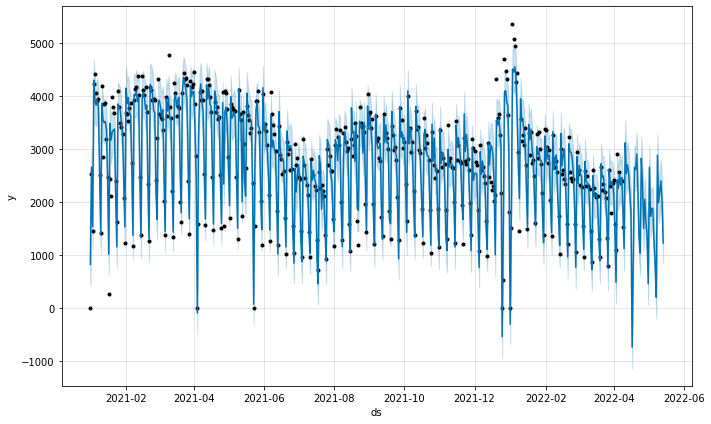

In [284]:
# Visualization
m.plot(forecast);

Blue line is the actual result, while blue means the result of forecast

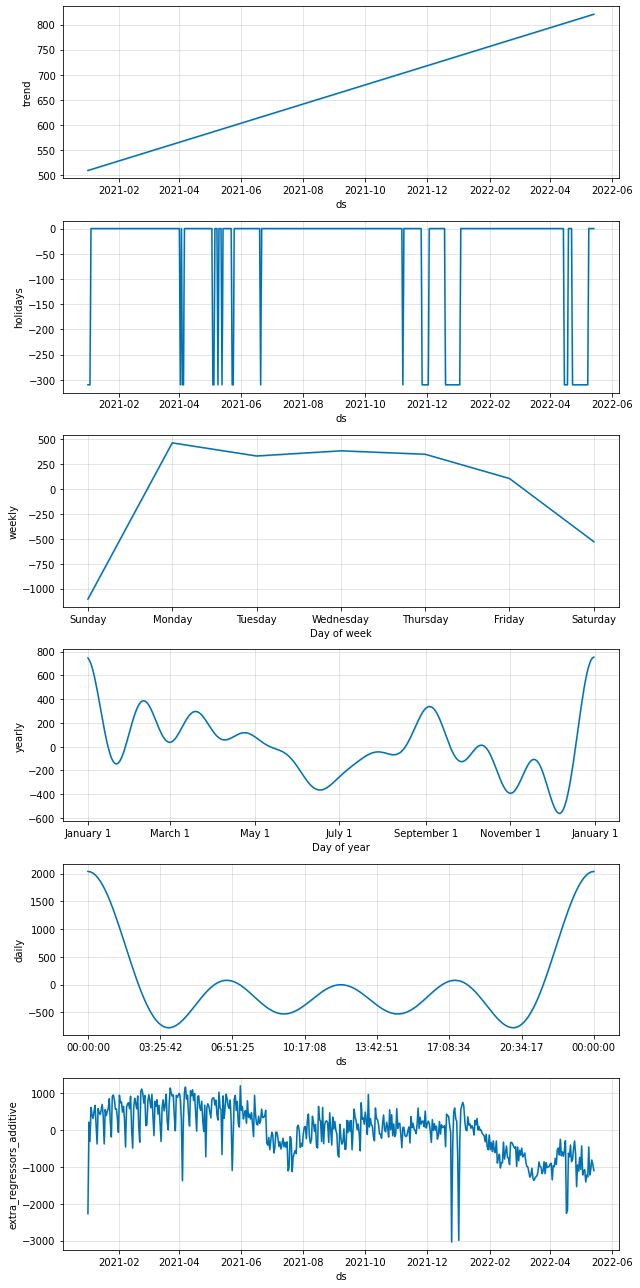

In [285]:
#plot components
m.plot_components(forecast);

Interpretation of the components:


*   Trend: annual trend. July is the peak season
*   Holiday: the positive part means that that day of holidays are giving more calls to CSC while negative means opposite
*   Week: Monday and Tuesday seems to haave more higher demand of call compared to the weekends
*   Yearly: doesn't seem to have really strong seasonality defined. March has higher demands than Feburary for example. Since the data contains 2.5 years, so it may not be enough to define the seasonality clearly.
*   Regressors: the regressors seem to have more impact on the outcome from 2021 or later.



In [286]:
predictions_prophet = predictions_prophet.rename('prophet')
predictions_prophet.index = prophet_test_set['ds']
predictions_prophet

ds
2022-04-10    1120.062893
2022-04-11    3116.266312
2022-04-12    2537.290439
2022-04-13    2700.711094
2022-04-14    2552.860788
                 ...     
2022-05-10    1985.635837
2022-05-11    2195.432128
2022-05-12    2398.228246
2022-05-13    2026.147602
2022-05-14    1226.499002
Name: prophet, Length: 35, dtype: float64

Text(0.5, 0, 'Date')

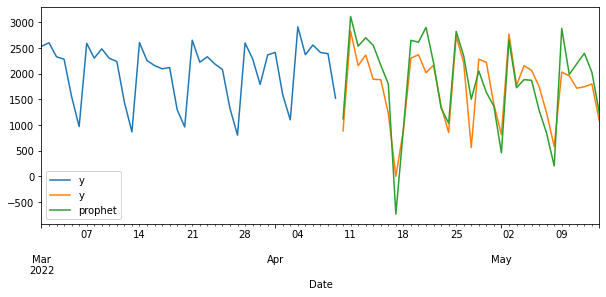

In [287]:
# Visualization
prophet_training_set.index = prophet_training_set.ds
prophet_test_set.index = prophet_test_set.ds


prophet_training_set.y['2022-03-01':].plot(figsize = (10,4), legend = True)
prophet_test_set.y.plot(legend = True)
predictions_prophet.plot(legend=True)

plt.xlabel('Date')

# Model 2: Hybrid

This combined model would meet both seasonality and nonlinearity of the dataset.

**Pros of XGBoost**
* XGBoost gives different weights depending on how difficult it is to predict the outcome over testing multiple trees. Thus, it gives greate weight on the predictor that had wrong outcome. This process continues until the model find the optimal wy for each observations.

* Helps preventing overfitting the model by looking at a fraction of the full dataset per tree. Thus, any dataset comes in the future won't be too must or less influenced.

* Weights are also distributed on different predictors per trees (not only on the data). thus, it creates more and more optimized model that sees what is important and slightly ignores predictions that are not as important.

* Treats NA values as information unlike other models

* non-linear relationship between dependent and independent variables


**Cons of XGBoost**
* complex programming
* can need intense optimization


In [288]:
# Spliting trainig and test set
FBXGB_training_set = dataset.iloc[:-test_days, :]
FBXGB_test_set = dataset.iloc[-test_days:, :]
FBXGB_training_set.head()

,index,y,Flevoland_Mid_Retail_Rec_%Change,Flevoland_Mid_Park_%Change,Flevoland_Std_Retail_Rec_%Change,...,Sun,stringency_index,new_cases_smoothed,new_deaths_smoothed,ds
0,2021-01-01,0.0,-81.0,3.0,2.627691,...,0.0,78.7,8560.714,86.571,2021-01-01
1,2021-01-02,2529.0,-64.0,-15.0,8.847921,...,0.0,78.7,8321.000,85.143,2021-01-02
2,2021-01-03,1446.0,-63.0,-7.0,6.928203,...,1.0,78.7,8199.286,87.857,2021-01-03
3,2021-01-04,4227.0,-50.0,-19.0,6.618157,...,0.0,78.7,8030.857,90.429,2021-01-04
4,2021-01-05,4420.0,-53.0,4.0,5.176872,...,0.0,78.7,7706.286,92.857,2021-01-05


**XGBoost Preparation**

In [289]:
# forecast is coming from the prophet model. The previous part may be not necessary
prophet_variables = forecast.loc[:, ['trend', 
                                     'weekly',
                                     'holi',
                                     'yearly',
                                     'daily'#choose variables from "forecast" dataframe
]]

In [290]:
dataset1 =dataset [[

'y', 'ds',

 'Gelderland_Mid_Retail_Rec_%Change', 'Gelderland_Mid_Park_%Change',
 'Gelderland_Std_Retail_Rec_%Change', 'Gelderland_Std_Park_%Change',
 'Gelderland_Ave_Retail_Rec_%Change', 'Gelderland_Ave_Park_%Change', 
 'Limburg_Std_Retail_Rec_%Change', 'Limburg_Std_Park_%Change',
 'Limburg_Mid_Retail_Rec_%Change', 'Limburg_Mid_Park_%Change',
 'Limburg_Ave_Retail_Rec_%Change', 'Limburg_Ave_Park_%Change',
 'North Brabant_Ave_Retail_Rec_%Change', 'North Brabant_Ave_Park_%Change',
 'North Brabant_Mid_Retail_Rec_%Change', 'North Brabant_Mid_Park_%Change',
 'North Brabant_Std_Retail_Rec_%Change', 'North Brabant_Std_Park_%Change',
 'Zeeland_Mid_Retail_Rec_%Change', 'Zeeland_Mid_Park_%Change',
 'Zeeland_Ave_Retail_Rec_%Change', 'Zeeland_Ave_Park_%Change',
 'Zeeland_Std_Retail_Rec_%Change', 'Zeeland_Std_Park_%Change',
 'Overijssel_Ave_Retail_Rec_%Change', 'Overijssel_Ave_Park_%Change',
 'Overijssel_Mid_Retail_Rec_%Change', 'Overijssel_Mid_Park_%Change',
 'Overijssel_Std_Retail_Rec_%Change', 'Overijssel_Std_Park_%Change',
 'North Holland_Mid_Retail_Rec_%Change', 'North Holland_Mid_Park_%Change',
 'North Holland_Ave_Retail_Rec_%Change', 'North Holland_Ave_Park_%Change',
 'North Holland_Std_Retail_Rec_%Change', 'North Holland_Std_Park_%Change',
 'Utrecht_Mid_Retail_Rec_%Change', 'Utrecht_Mid_Park_%Change',
 'Utrecht_Ave_Retail_Rec_%Change', 'Utrecht_Ave_Park_%Change',
 'Utrecht_Std_Retail_Rec_%Change', 'Utrecht_Std_Park_%Change',
 'Flevoland_Ave_Retail_Rec_%Change', 'Flevoland_Ave_Park_%Change',
 'Flevoland_Mid_Retail_Rec_%Change', 'Flevoland_Mid_Park_%Change',
 'Flevoland_Std_Retail_Rec_%Change', 'Flevoland_Std_Park_%Change',
 'South Holland_Mid_Retail_Rec_%Change', 'South Holland_Mid_Park_%Change',
 'South Holland_Std_Retail_Rec_%Change', 'South Holland_Std_Park_%Change',
 'South Holland_Ave_Retail_Rec_%Change', 'South Holland_Ave_Park_%Change',
 'Groningen_Std_Retail_Rec_%Change', 'Groningen_Std_Park_%Change',
 'Groningen_Mid_Retail_Rec_%Change', 'Groningen_Mid_Park_%Change',
 'Groningen_Ave_Retail_Rec_%Change', 'Groningen_Ave_Park_%Change',
 'Friesland_Ave_Retail_Rec_%Change', 'Friesland_Ave_Park_%Change',
 'Friesland_Mid_Retail_Rec_%Change', 'Friesland_Mid_Park_%Change',
 'Friesland_Std_Retail_Rec_%Change', 'Friesland_Std_Park_%Change',
 'Drenthe_Mid_Retail_Rec_%Change', 'Drenthe_Mid_Park_%Change',
 'Drenthe_Ave_Retail_Rec_%Change', 'Drenthe_Ave_Park_%Change',
 'Drenthe_Std_Retail_Rec_%Change', 'Drenthe_Std_Park_%Change',
 'DDVEC', 'FHVEC', 'FG', 'FXX', 'TG', 'TN', 'TX', 'SQ', 'NG', 'RH',
 'christmas_NY', 'easter_whit',
 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun',
 'stringency_index',  'new_cases_smoothed', 'new_deaths_smoothed',

         ]]

In [291]:
# merge the dataset variables and prphet result
df_xgb = pd.concat([dataset1, prophet_variables], axis = 1) 

In [292]:
pd.set_option('display.max_rows', None)
df_xgb[df_xgb.columns[0:]].corr()['y'][:-1].round(3).abs().sort_values(ascending=False)

y                                       1.000
weekly                                  0.736
Sun                                     0.595
stringency_index                        0.420
Flevoland_Std_Retail_Rec_%Change        0.416
Overijssel_Std_Retail_Rec_%Change       0.405
Gelderland_Std_Retail_Rec_%Change       0.384
South Holland_Std_Retail_Rec_%Change    0.365
trend                                   0.365
North Holland_Std_Retail_Rec_%Change    0.361
North Holland_Std_Park_%Change          0.346
Utrecht_Std_Park_%Change                0.329
Groningen_Std_Park_%Change              0.327
Limburg_Std_Retail_Rec_%Change          0.323
Drenthe_Std_Retail_Rec_%Change          0.321
Sat                                     0.309
Mon                                     0.295
Zeeland_Std_Retail_Rec_%Change          0.295
Utrecht_Std_Retail_Rec_%Change          0.286
Groningen_Std_Retail_Rec_%Change        0.267
Friesland_Std_Retail_Rec_%Change        0.258
Flevoland_Std_Park_%Change        

In [293]:
# Now you can see the seasonality data from Prophet is with the other features
df_xgb.head()

,y,ds,Gelderland_Mid_Retail_Rec_%Change,Gelderland_Mid_Park_%Change,Gelderland_Std_Retail_Rec_%Change,...,trend,weekly,holi,yearly,daily
0,0.0,2021-01-01,-83.0,-3.0,6.431669,...,509.250361,105.411548,-309.945762,746.489756,2038.624735
1,2529.0,2021-01-02,-70.0,-5.0,8.904623,...,509.875429,-528.241496,-309.945762,729.137930,2038.624735
2,1446.0,2021-01-03,-62.0,2.5,13.383484,...,510.500497,-1104.392416,-309.945762,702.055333,2038.624735
3,4227.0,2021-01-04,-54.0,-13.0,9.631274,...,511.125565,463.367155,0.000000,666.005975,2038.624735
4,4420.0,2021-01-05,-53.5,-9.5,10.353520,...,511.750632,331.493192,0.000000,621.932971,2038.624735


In [294]:
# Create Training and Testing dataset
FBXGBcombined_training_set = df_xgb.iloc[:-test_days, :]
FBXGBcombined_test_set = df_xgb.iloc[-test_days:, :]
FBXGBcombined_training_set.head()

,y,ds,Gelderland_Mid_Retail_Rec_%Change,Gelderland_Mid_Park_%Change,Gelderland_Std_Retail_Rec_%Change,...,trend,weekly,holi,yearly,daily
0,0.0,2021-01-01,-83.0,-3.0,6.431669,...,509.250361,105.411548,-309.945762,746.489756,2038.624735
1,2529.0,2021-01-02,-70.0,-5.0,8.904623,...,509.875429,-528.241496,-309.945762,729.137930,2038.624735
2,1446.0,2021-01-03,-62.0,2.5,13.383484,...,510.500497,-1104.392416,-309.945762,702.055333,2038.624735
3,4227.0,2021-01-04,-54.0,-13.0,9.631274,...,511.125565,463.367155,0.000000,666.005975,2038.624735
4,4420.0,2021-01-05,-53.5,-9.5,10.353520,...,511.750632,331.493192,0.000000,621.932971,2038.624735


In [295]:
# isolate X and Y
y_train = FBXGBcombined_training_set.y
y_test = FBXGBcombined_test_set.y

X_train = FBXGBcombined_training_set.drop(columns = {'y', 'ds'})
X_test = FBXGBcombined_test_set.drop(columns = {'y', 'ds'})

In [296]:
# create XGBoost Matrices
Train = xgb.DMatrix(data = X_train, label = y_train)
Test = xgb.DMatrix(data = X_test, label = y_test)

**Parameters**
* **Minimum Child Weight**: relates to the sum of the weight of each obervation. Low values can mean that maybe not a lot of observations are in the round.
* **ETA**: learning rate; how fast does the model needs to learn? lower learning rate usually
* **Max depth**: how many splits should the tree have? the larger trees, further detailed.
* **Gamma**: how easy and fast should the tree be split? faster? longer?
* **Subsample**: share of observation in each tree? 
* **Colsample by tree**: how much of the tree should be analyzed per round?
* **numbe of rounds**: How many times do we want the analysis to be run?

In [297]:
# XGBoost Parameters
parameters = {'learning_rate': 0.1, # this is usually changed
              'max_depth': 3, # this is usually changed
              'colsample_bytree': 1,
              'subsample': 1,
              'min_child_weight':1,
              'gamma': 1,
              'random_state': 1502,
              'eval_metric': 'rmse',
              'objective': "reg:squarederror"
}

In [298]:
# Modeling
model_fbxgb = xgb.train(params = parameters,
                  dtrain = Train,
                  num_boost_round = 100, # after 100 the rmse may increase more again.
                  evals = [(Test, 'y')],
                  verbose_eval = 15 
                  ) #how much do we want the model to speak with us? Larger the value, more communicate with us
                  

[0]	y-rmse:1632.06
[15]	y-rmse:494.436
[30]	y-rmse:720.438
[45]	y-rmse:745.044
[60]	y-rmse:752.013
[75]	y-rmse:736.783
[90]	y-rmse:741.214
[99]	y-rmse:743.293


In [299]:
# Forecasting
predictions_xgb = pd.Series(model_fbxgb.predict(Test), name = 'XGBoost')
predictions_xgb.index = FBXGBcombined_test_set.ds

In [300]:
predictions_xgb[:5]

ds
2022-04-10    1073.324951
2022-04-11    2598.811279
2022-04-12    2341.844238
2022-04-13    2338.731445
2022-04-14    2544.403564
Name: XGBoost, dtype: float32

In [301]:
# Visualization
FBXGBcombined_training_set.index = FBXGBcombined_training_set.ds
FBXGBcombined_test_set.index = FBXGBcombined_test_set.ds

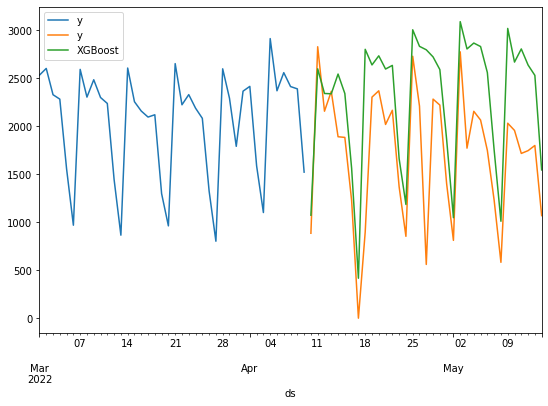

In [302]:
FBXGBcombined_training_set.y['2022-03-01':].plot(figsize = (9,6), legend = True)
FBXGBcombined_test_set.y.plot(legend = True)
predictions_xgb.plot(legend = True)

P: order of the autoregressive\
D: degree of first differencing involved\
Q: order of the moving average part\

# Model 3: Ensembled Model

In [303]:
# dfprophet = pd.DataFrame(predictions_prophet)
actual = volume_ground[['Demand(y)']]
actual.reset_index(inplace=True)
actual = actual.rename(columns = {'index':'Date'})

dfprophet = pd.DataFrame(predictions_prophet)
dfprophet.reset_index(inplace=True)
dfprophet = dfprophet.rename(columns = {'ds':'Date', 'prophet':'Prophet_Prediction'})

dfxgb = pd.DataFrame(predictions_xgb)
dfxgb.reset_index(inplace=True)
dfxgb = dfxgb.rename(columns = {'ds':'Date', 'XGBoost':'prediction'})

fboxfb = dfxgb.rename(columns = {'prediction':'Prophet + XGB'}) 
fbp = dfprophet.rename(columns = {'Prophet_Prediction':'Prophet'}) 

ensembled = pd.merge(fbp , fboxfb, left_on='Date', right_on='Date')
ensembled = pd.merge(ensembled , actual, left_on='Date', right_on='Date')

ensembled = ensembled [['Date',  'Demand(y)', 'Prophet', 'Prophet + XGB']]
ensembled['Ensembled'] = (ensembled ['Prophet']+ensembled ['Prophet + XGB'])/2
ens = ensembled.Ensembled
ens.index = FBXGBcombined_test_set.ds

#**Phase 3: Future Prediction**

In this section, we repeat the modeling process with future values.\
1. Data: Each data needs to have future values. 
2. Models: Run models using future values.
3. Assessment: Review the statistic scores and compare with the testing phase.
4. Download: Get the forecasting values in CSV file.

# Prep: "Dataset" and "Holidays"

In [304]:
# bring the date index into column
dataset_future = all_future.reset_index()
dataset_future['Date'] = dataset_future['index'].dt.strftime('%Y-%m-%d')
# data = data.drop(['index'], axis =1)

In [305]:
# Data Transformation
dataset_future.Date = pd.to_datetime(dataset_future.Date, format = '%Y-%m-%d')

In [306]:
# Due to the requirement of FBProphet, rename y column and datastamp variables
dataset_future = dataset_future.rename(columns= {'Demand(y)':'y'})
dataset_future = dataset_future.rename(columns= {'Date':'ds'})


In [307]:
#Holidays
holiday_dates = dataset_future[dataset_future.Holidays == 1].ds
holidays = pd.DataFrame({'holiday': 'holi', 
                         'ds':pd.to_datetime(holiday_dates),
                         #'lower_window':0, #3 days prior to the holiday that was counted
                         #'upper_window':0  
                         #1 day after to the holiday that was counted
})                       #upper and lower can be 0 as they are manually specified
holidays.head()

,holiday,ds
0,holi,2021-01-01
1,holi,2021-01-02
2,holi,2021-01-03
91,holi,2021-04-02
93,holi,2021-04-04


In [308]:
#remove Holidays columns from dataset as the holidays are created seperately.
dataset_future = dataset_future.drop(columns = "Holidays")
dataset_future = dataset_future.fillna(0)
dataset_future.head(2)

,index,y,DDVEC,FHVEC,FG,...,Limburg_Std_Retail_Rec_%Change,Limburg_Std_Park_%Change,Limburg_Mid_Retail_Rec_%Change,Limburg_Mid_Park_%Change,ds
0,2021-01-01,0.0,231.0,25.0,28.0,...,5.993661,16.231656,-79.0,-21.0,2021-01-01
1,2021-01-02,2529.0,203.0,15.0,22.0,...,8.400113,22.311839,-71.0,-23.0,2021-01-02


# Model 1: Prophet



**Benefit of Prophet Model**\
(+) dynamic holidays; it allows us to further dig and study about holidays\
(+) customizable and intuitive for non-experts; built-in cross validation and hyperparameter tuning\


**Methodological framework**\
y(t) = c(t)+s(t)+h(t)+x(t)+e

where c(t) = trent, s(t) = seasonality, and h(t) = holiday effects, x(t) = external variables/regressors, and e = error

In [309]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Seperating the dataset into Training and Testing
"""""""""""""""""""""""""""""""""""""""""""""""""""
prophet_training_set_future = dataset_future.iloc[:-test_days, :]
prophet_test_set_future = dataset_future.iloc[-test_days:, :]

**Facebook Prophet Component Descriptions**


*   **Growth** : Linear / Logistic ; how does the trend shape like?
*   **Holidays**: use the one prepared already above
*   **Seasonality**: yearly, weekly, daily
*   **Seasonality_mode**: multiplicative or additive
*   **Seasonality_Prior_scale**: strength of the seasonality (continous number). higher number means stronger seasonality
*   **Holiday_Prior_scale**: strength of the holiday (continous number)
*   **Changepoint_prior_scale**: flexibility of the automatic changepoint selection: how to detect the changes in trend and whether it should detect changes in trend easily or more robust




In [310]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Facebook Prophet Model
"""""""""""""""""""""""""""""""""""""""""""""""""""
mf = Prophet(growth = 'linear',
            yearly_seasonality=True, #Jan to Feb etc
            weekly_seasonality=True, #monday to sunday seasonality
            daily_seasonality= True, #if data is daily, then True
            holidays = holidays, #it was already defined earlier
            seasonality_mode ='additive', #use additive seasonality during the pandemic so that it’s not biased by 2020’s abnormal baseline, especially when COVID greatly impacts your time series data.
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05 #this is more to leave it to the model and reflect how easy it is to have a break of trends
            )



# Selected Features
mf.add_regressor('Drenthe_Std_Retail_Rec_%Change')
mf.add_regressor('Drenthe_Std_Park_%Change')
mf.add_regressor('Groningen_Std_Retail_Rec_%Change')
mf.add_regressor('Zeeland_Std_Retail_Rec_%Change')
mf.add_regressor('South Holland_Std_Retail_Rec_%Change')
mf.add_regressor('South Holland_Std_Park_%Change')
mf.add_regressor('North Brabant_Std_Retail_Rec_%Change')
mf.add_regressor('North Brabant_Std_Park_%Change')
mf.add_regressor('Friesland_Std_Retail_Rec_%Change')
mf.add_regressor('Gelderland_Std_Retail_Rec_%Change')
mf.add_regressor('Gelderland_Std_Park_%Change')
mf.add_regressor('Utrecht_Std_Retail_Rec_%Change')
mf.add_regressor('Utrecht_Std_Park_%Change')
mf.add_regressor('Limburg_Std_Retail_Rec_%Change')
mf.add_regressor('Limburg_Std_Park_%Change')
mf.add_regressor('North Holland_Std_Retail_Rec_%Change')
mf.add_regressor('North Holland_Std_Park_%Change')
mf.add_regressor('Overijssel_Std_Retail_Rec_%Change')
mf.add_regressor('stringency_index')
mf.add_regressor('DDVEC')
mf.add_regressor('FHVEC')
mf.add_regressor('FG')
mf.add_regressor('FXX')
mf.add_regressor('TG')
mf.add_regressor('TN')
mf.add_regressor('TX')
mf.add_regressor('NG')

# # no change ; 18
mf.add_regressor('christmas_NY')
mf.add_regressor('easter_whit')
mf.add_regressor('Mon')
mf.add_regressor('Tue')
mf.add_regressor('Wed')
mf.add_regressor('Thu')
mf.add_regressor('Fri')
mf.add_regressor('Sat')
mf.add_regressor('Sun')



mf.fit(prophet_training_set_future)

In [311]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Forecasting
"""""""""""""""""""""""""""""""""""""""""""""""""""
# Create Future Dataframe
ffuture = mf.make_future_dataframe(periods = len(prophet_test_set_future),
                                 freq = "D")
ffuture.tail(1)

,ds
534,2022-06-19


In [312]:
# merge regressors
ffuture = pd.concat([ffuture, dataset_future.iloc[:, 1:-1]], # do not include "ds" and 'y' columns
                    axis = 1)
ffuture.head()

,ds,y,DDVEC,FHVEC,FG,...,Limburg_Ave_Park_%Change,Limburg_Std_Retail_Rec_%Change,Limburg_Std_Park_%Change,Limburg_Mid_Retail_Rec_%Change,Limburg_Mid_Park_%Change
0,2021-01-01,0.0,231.0,25.0,28.0,...,-20.666667,5.993661,16.231656,-79.0,-21.0
1,2021-01-02,2529.0,203.0,15.0,22.0,...,-21.727273,8.400113,22.311839,-71.0,-23.0
2,2021-01-03,1446.0,47.0,47.0,48.0,...,-7.600000,10.232069,23.027520,-68.0,-8.0
3,2021-01-04,4227.0,47.0,71.0,72.0,...,-18.166667,5.686241,13.317908,-56.5,-20.5
4,2021-01-05,4420.0,51.0,56.0,56.0,...,-12.000000,5.599648,14.798649,-55.0,-19.0


In [313]:
#Forecasting
fforecast = mf.predict(ffuture)
fforecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,...,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,529.112415,320.933646,1290.517826,529.112415,...,159.592155,0.0,0.0,0.0,782.048265
1,2021-01-02,529.664559,2408.069268,3403.532892,529.664559,...,153.056889,0.0,0.0,0.0,2900.162274
2,2021-01-03,530.216702,1585.449638,2607.378767,530.216702,...,138.912985,0.0,0.0,0.0,2086.985920
3,2021-01-04,530.768846,3888.681446,4869.522929,530.768846,...,117.469609,0.0,0.0,0.0,4380.640178
4,2021-01-05,531.320989,3668.702327,4599.556275,531.320989,...,89.178273,0.0,0.0,0.0,4130.658058


In [314]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Prediction
"""""""""""""""""""""""""""""""""""""""""""""""""""
predictions_prophet_future = fforecast.yhat[-test_days:].rename('prophet')
predictions_prophet_future[:5]

500    2291.065227
501    1961.676516
502    1948.477335
503    1996.671862
504    1836.401393
Name: prophet, dtype: float64

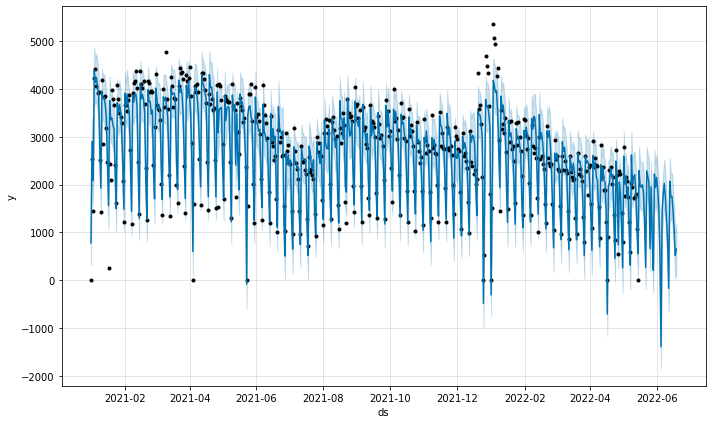

In [315]:
# Visualization
mf.plot(fforecast);

Blue line is the actual result, while blue means the result of forecast

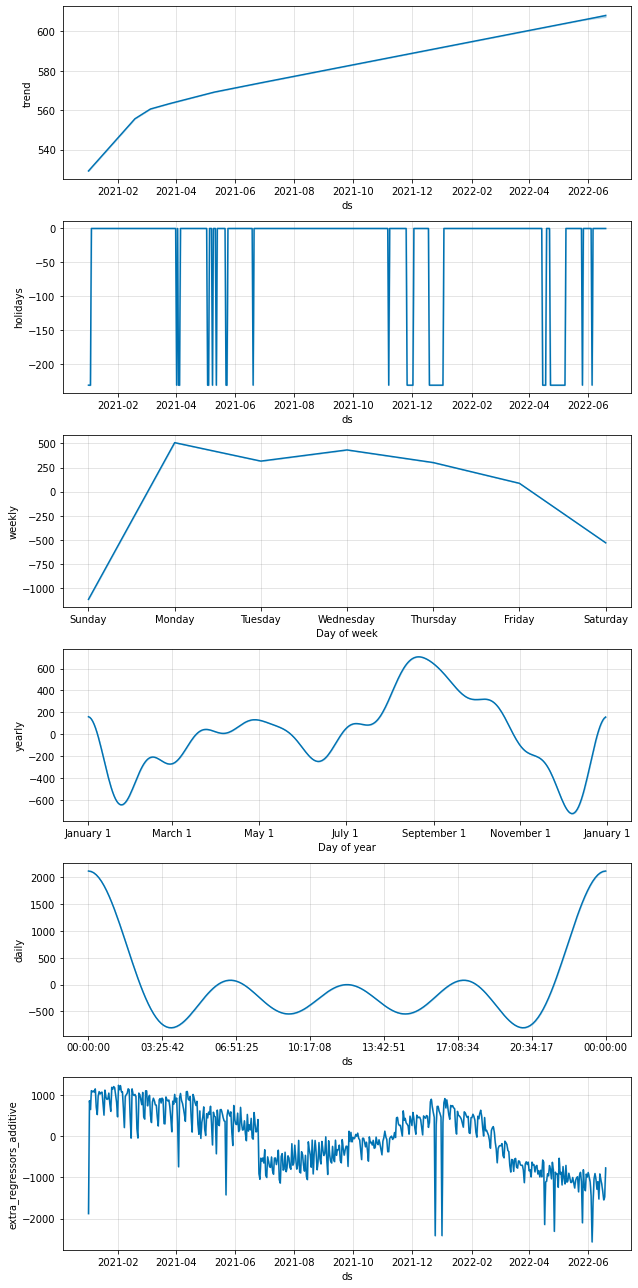

In [316]:
#plot components
mf.plot_components(fforecast);

Interpretation of the components:


*   Trend: annual trend. July is the peak season
*   Holiday: the positive part means that that day of holidays are giving more calls to CSC while negative means opposite
*   Week: Monday and Tuesday seems to haave more higher demand of call compared to the weekends
*   Yearly: doesn't seem to have really strong seasonality defined. March has higher demands than Feburary for example. Since the data contains 2.5 years, so it may not be enough to define the seasonality clearly.
*   Regressors: the regressors seem to have more impact on the outcome from 2021 or later.



In [317]:
predictions_prophet_future = predictions_prophet_future.rename('prophet')
predictions_prophet_future.index = prophet_test_set_future['ds']
predictions_prophet_future

ds
2022-05-16    2291.065227
2022-05-17    1961.676516
2022-05-18    1948.477335
2022-05-19    1996.671862
2022-05-20    1836.401393
2022-05-21    1235.026888
2022-05-22     272.478298
2022-05-23    2289.125146
2022-05-24    2158.996410
2022-05-25    2040.328202
2022-05-26     661.601835
2022-05-27    1951.534425
2022-05-28     901.939755
2022-05-29     207.722570
2022-05-30    2220.221319
2022-05-31    1938.976459
2022-06-01    2149.282918
2022-06-02    1885.509674
2022-06-03    1539.434758
2022-06-04     567.980152
2022-06-05   -1383.497580
2022-06-06    1426.444060
2022-06-07    1788.765091
2022-06-08    2022.561919
2022-06-09    1740.351883
2022-06-10    1279.490092
2022-06-11     842.314834
2022-06-12    -166.559548
2022-06-13    2070.278246
2022-06-14    1745.954417
2022-06-15    1749.509316
2022-06-16    1454.293392
2022-06-17    1048.165900
2022-06-18     518.825425
2022-06-19     651.047789
Name: prophet, dtype: float64

Text(0.5, 0, 'Date')

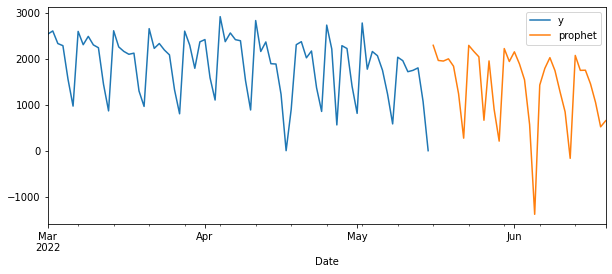

In [318]:
# Visualization
prophet_training_set_future.index = prophet_training_set_future.ds
prophet_test_set_future.index = prophet_test_set_future.ds


prophet_training_set_future.y['2022-03-01':].plot(figsize = (10,4), legend = True)
# prophet_test_set_future.y.plot(legend = True)
predictions_prophet_future.plot(legend=True)

plt.xlabel('Date')

In [319]:
'''no metrics can be applied as there are no values to compare with for y and yhat'''
# timeseries_evaluation_metrics_func(actual_value_future, predictions_prophet_future)

'no metrics can be applied as there are no values to compare with for y and yhat'

# Model 2: Hybrid

This combined model would meet both seasonality and nonlinearity of the dataset.

**Pros of XGBoost**
* XGBoost gives different weights depending on how difficult it is to predict the outcome over testing multiple trees. Thus, it gives greate weight on the predictor that had wrong outcome. This process continues until the model find the optimal wy for each observations.

* Helps preventing overfitting the model by looking at a fraction of the full dataset per tree. Thus, any dataset comes in the future won't be too must or less influenced.

* Weights are also distributed on different predictors per trees (not only on the data). thus, it creates more and more optimized model that sees what is important and slightly ignores predictions that are not as important.

* Treats NA values as information unlike other models

* non-linear relationship between dependent and independent variables


**Cons of XGBoost**
* complex programming
* can need intense optimization


In [320]:
# Spliting trainig and test set
FBXGB_training_set = dataset_future.iloc[:-test_days, :]
FBXGB_test_set = dataset_future.iloc[-test_days:, :]

**XGBoost Preparation**

In [321]:
prophet_variables = fforecast.loc[:, ['trend', 
                                     'weekly',
                                     'holi',
                                     'yearly',
                                     'daily'#choose variables from "forecast" dataframe
]]

In [322]:
dataset1 = dataset_future[[

'y', 'ds', 

#selected features
'Drenthe_Std_Retail_Rec_%Change',
'Drenthe_Std_Park_%Change',
'Groningen_Std_Retail_Rec_%Change',
'Zeeland_Std_Retail_Rec_%Change',
'South Holland_Std_Retail_Rec_%Change',
'South Holland_Std_Park_%Change',
'North Brabant_Std_Retail_Rec_%Change',
'North Brabant_Std_Park_%Change',
'Friesland_Std_Retail_Rec_%Change',
'Gelderland_Std_Retail_Rec_%Change',
'Gelderland_Std_Park_%Change',
'Utrecht_Std_Retail_Rec_%Change',
'Utrecht_Std_Park_%Change',
'Limburg_Std_Retail_Rec_%Change',
'Limburg_Std_Park_%Change',
'North Holland_Std_Retail_Rec_%Change',
'North Holland_Std_Park_%Change',
'Overijssel_Std_Retail_Rec_%Change',
'stringency_index',
'DDVEC',
'FHVEC',
'FG',
'FXX',
'TG',
'TN',
'TX',
'NG',


# no change ; 18
'christmas_NY',
'easter_whit',
'Mon',
'Tue',
'Wed',
'Thu',
'Fri',
'Sat',
'Sun',

        ]]

Chooing Only XGB for now with/without Seasonality

In [323]:
# merge the dataset variables and prphet result
df_xgb = pd.concat([dataset1, prophet_variables], axis = 1) 

In [324]:
# Create Training and Testing dataset
FBXGBcombined_training_set = df_xgb.iloc[:-test_days, :]
FBXGBcombined_test_set = df_xgb.iloc[-test_days:, :]
FBXGBcombined_training_set.head()

,y,ds,Drenthe_Std_Retail_Rec_%Change,Drenthe_Std_Park_%Change,Groningen_Std_Retail_Rec_%Change,...,trend,weekly,holi,yearly,daily
0,0.0,2021-01-01,6.085045,21.484878,4.026697,...,529.112415,86.684905,-230.815529,159.592155,2117.444208
1,2529.0,2021-01-02,6.219146,23.499747,7.778175,...,529.664559,-529.849866,-230.815529,153.056889,2117.444208
2,1446.0,2021-01-03,6.582806,20.297343,8.173127,...,530.216702,-1117.115752,-230.815529,138.912985,2117.444208
3,4227.0,2021-01-04,8.238123,7.266361,5.442338,...,530.768846,508.502289,0.000000,117.469609,2117.444208
4,4420.0,2021-01-05,7.763161,10.754844,5.006662,...,531.320989,317.036126,0.000000,89.178273,2117.444208


In [325]:
# isolate X and Y
y_train = FBXGBcombined_training_set.y
y_test = FBXGBcombined_test_set.y

X_train = FBXGBcombined_training_set.drop(columns = {'y', 'ds'})
X_test = FBXGBcombined_test_set.drop(columns = {'y', 'ds'})

In [326]:
# create XGBoost Matrices
Train = xgb.DMatrix(data = X_train, label = y_train)
Test = xgb.DMatrix(data = X_test, label = y_test)

**Parameters**
* **Minimum Child Weight**: relates to the sum of the weight of each obervation. Low values can mean that maybe not a lot of observations are in the round.
* **ETA**: learning rate; how fast does the model needs to learn? lower learning rate usually
* **Max depth**: how many splits should the tree have? the larger trees, further detailed.
* **Gamma**: how easy and fast should the tree be split? faster? longer?
* **Subsample**: share of observation in each tree? 
* **Colsample by tree**: how much of the tree should be analyzed per round?
* **numbe of rounds**: How many times do we want the analysis to be run?

In [327]:
# XGBoost Parameters
parameters = {'learning_rate': 0.1, # this is usually changed
              'max_depth': 3, # this is usually changed
              'colsample_bytree': 1,
              'subsample': 1,
              'min_child_weight':1,
              'gamma': 1,
              'random_state': 1502,
              'eval_metric': 'rmse',
              'objective': "reg:squarederror"
}

In [328]:
# Modeling
model_fbxgb_f = xgb.train(params = parameters,
                  dtrain = Train,
                  num_boost_round = 100, # after 100 the rmse may increase more again.
                  evals = [(Test, 'y')],
                  verbose_eval = 15 
                  ) #how much do we want the model to speak with us? Larger the value, more communicate with us
                  

[0]	y-rmse:199.312
[15]	y-rmse:1582.48
[30]	y-rmse:1815.11
[45]	y-rmse:1792.03
[60]	y-rmse:1755.08
[75]	y-rmse:1719.87
[90]	y-rmse:1707.95
[99]	y-rmse:1708.57


In [329]:
# Forecasting
predictions_xgb_future = pd.Series(model_fbxgb_f.predict(Test), name = 'XGBoost')
predictions_xgb_future.index = FBXGBcombined_test_set.ds

In [330]:
predictions_xgb_future[:5]

ds
2022-05-16    2349.513672
2022-05-17    1987.916992
2022-05-18    1846.128296
2022-05-19    1854.001709
2022-05-20    1929.597656
Name: XGBoost, dtype: float32

In [331]:
# Visualization
FBXGBcombined_training_set.index = FBXGBcombined_training_set.ds
FBXGBcombined_test_set.index = FBXGBcombined_test_set.ds

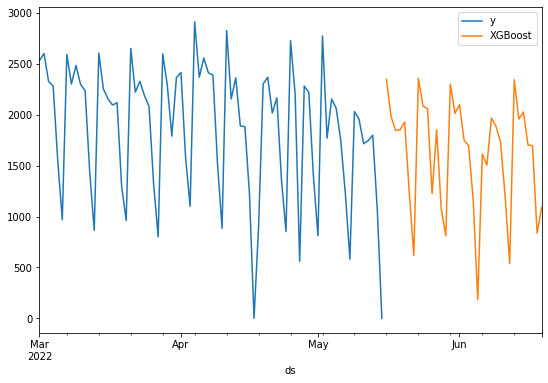

In [332]:
FBXGBcombined_training_set.y['2022-03-01':].plot(figsize = (9,6), legend = True)
# FBXGBcombined_test_set.y.plot(legend = True)f
predictions_xgb_future.plot(legend = True)

In [333]:
# timeseries_evaluation_metrics_func(actual_value_future, predictions_xgb_future)

# Model 3: Ensembled Model

In [334]:
dfprophet = pd.DataFrame(predictions_prophet_future)
dfprophet.reset_index(inplace=True)
dfprophet = dfprophet.rename(columns = {'ds':'Date', 'prophet':'Prophet_Prediction'})

dfxgb = pd.DataFrame(predictions_xgb_future)
dfxgb.reset_index(inplace=True)
dfxgb = dfxgb.rename(columns = {'ds':'Date', 'XGBoost':'prediction'})

fboxfb = dfxgb.rename(columns = {'prediction':'Prophet + XGB'}) 
fbp = dfprophet.rename(columns = {'Prophet_Prediction':'Prophet'}) 

ensembled2 = pd.merge(fbp , fboxfb, left_on='Date', right_on='Date')

ensembled2 = ensembled2 [['Date', # 'Demand(y)',
                        'Prophet', 'Prophet + XGB']]
ensembled2['Ensembled'] = (ensembled2 ['Prophet'] + ensembled2 ['Prophet + XGB'])/2
ens2 = ensembled2.Ensembled
ens2.index = FBXGBcombined_test_set.ds

In [335]:
ensembled2

,Date,Prophet,Prophet + XGB,Ensembled
0,2022-05-16,2291.065227,2349.513672,2320.289449
1,2022-05-17,1961.676516,1987.916992,1974.796754
2,2022-05-18,1948.477335,1846.128296,1897.302815
3,2022-05-19,1996.671862,1854.001709,1925.336785
4,2022-05-20,1836.401393,1929.597656,1882.999525
5,2022-05-21,1235.026888,1239.092896,1237.059892
6,2022-05-22,272.478298,618.871887,445.675093
7,2022-05-23,2289.125146,2359.593750,2324.359448
8,2022-05-24,2158.996410,2087.885498,2123.440954
9,2022-05-25,2040.328202,2060.681152,2050.504677


# **Phase 4: Prediction Result**

Assessment Result and Graph for Test Models

In [336]:
ensembled.loc[ensembled['Demand(y)']==0, ['Prophet','Prophet + XGB','Ensembled']]=0

ensembled['ratio'] = round((ensembled['Prophet + XGB']-ensembled['Demand(y)'])/ensembled['Demand(y)']*100, 2)
ensembled['ratio'] = ensembled['ratio'].replace(np.nan, 0)
# comparison = comparison[['Date', 'Prophet + XGB', 'Demand(y)', 'ratio']]
ensembled = ensembled.loc[(ensembled['Demand(y)']>0)]
pd.set_option('display.max_rows', None)
ensembled.head(5)

,Date,Demand(y),Prophet,Prophet + XGB,Ensembled,ratio
0,2022-04-10,885.0,1120.062893,1073.324951,1096.693922,21.28
1,2022-04-11,2829.0,3116.266312,2598.811279,2857.538796,-8.14
2,2022-04-12,2157.0,2537.290439,2341.844238,2439.567338,8.57
3,2022-04-13,2364.0,2700.711094,2338.731445,2519.721270,-1.07
4,2022-04-14,1891.0,2552.860788,2544.403564,2548.632176,34.55


In [337]:
print('------IS Prophet------')
timeseries_evaluation_metrics_func(ensembled['Demand(y)'], ensembled['Prophet'])

print('------IS XGB------')
timeseries_evaluation_metrics_func(ensembled['Demand(y)'], ensembled['Prophet + XGB'])

print('------IS Ensembled------')
timeseries_evaluation_metrics_func(ensembled['Demand(y)'], ensembled['Ensembled'])


------IS Prophet------
Evaluation metric results:-
MSE is : 169909.5565821719
MAE is : 328.3551095295032
RMSE is : 412.20086921569185
MAPE is : 23.898372450284256
R2 is : 0.5559974257720255

------IS XGB------
Evaluation metric results:-
MSE is : 563633.4787009886
MAE is : 602.0756674373852
RMSE is : 750.7552721766185
MAPE is : 47.077107617006035
R2 is : -0.4728701580907173

------IS Ensembled------
Evaluation metric results:-
MSE is : 249050.87442330396
MAE is : 375.9607563012892
RMSE is : 499.0499718698559
MAPE is : 28.924436066874758
R2 is : 0.3491876997266101



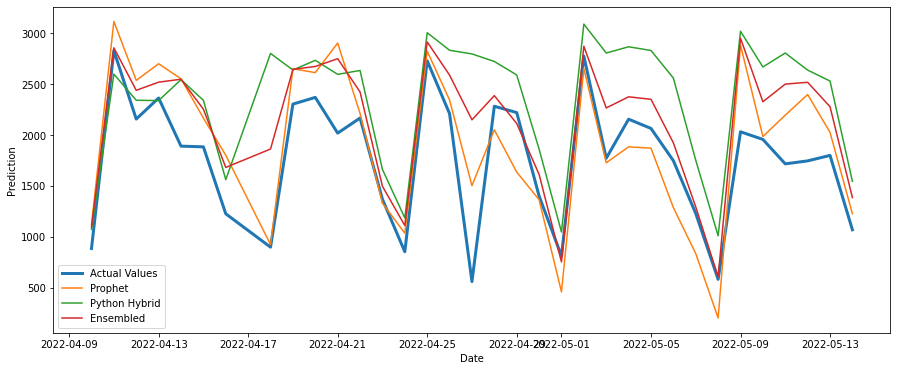

In [338]:
plt.figure(figsize=(15, 6))
sns.lineplot(x= 'Date', y='Demand(y)', data= ensembled, palette = colors,  linewidth = 3, label = 'Actual Values')
sns.lineplot(x= 'Date', y='Prophet', data= ensembled, palette = colors, label = 'Prophet')
sns.lineplot(x= 'Date', y='Prophet + XGB', data= ensembled, palette = colors, label = 'Python Hybrid')
sns.lineplot(x= 'Date', y='Ensembled', data= ensembled, palette = colors, label = 'Ensembled')

plt.xlabel('Date')
plt.ylabel('Prediction')
# plt.title('Multivariate Time Series Forecasting Prediction Comparison',)
plt.legend()
# fig.autofmt_xdate()
plt.show()

# **Phase 5: Feature Importance**

Shapely Additive Explanations (ShAP):

This method is considered somewhat better than the traditional sckit-learn methods because many of these methods can be inconsistent, which means that the features that are most important may not always be given the highest feature importance score.

the tree-based models which might give two equally important features different scores based on what level of splitting was done using the features.

The features which split the model first might be given higher importance. This is the motivation for using the latest feature attribution method, Shapley Additive Explanations.

We estimate how important a model is by seeing how well the model performs with and without that feature for every combination of features.

This value is the average marginal contribution of a feature value across all the possible combinations of features.The computation time increases exponentially with the number of features. [Link](https://towardsdatascience.com/a-novel-approach-to-feature-importance-shapley-additive-explanations-d18af30fc21b/)







In [339]:
!pip install shap 
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [340]:
explainer = shap.TreeExplainer(model_fbxgb_f)

In [341]:
shap_values = explainer.shap_values(X_train, check_additivity=False)

SHAP summary plot gives a general overview of each feature a SHAP dependence plot show how the model output varies by feauture value. Note that every dot is a data point, and the vertical dispersion at a single feature value results from interaction effects in the model.

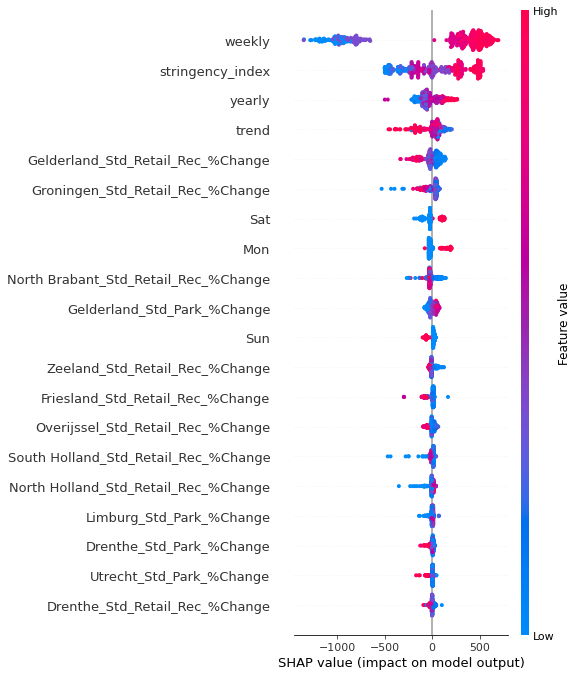

In [342]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

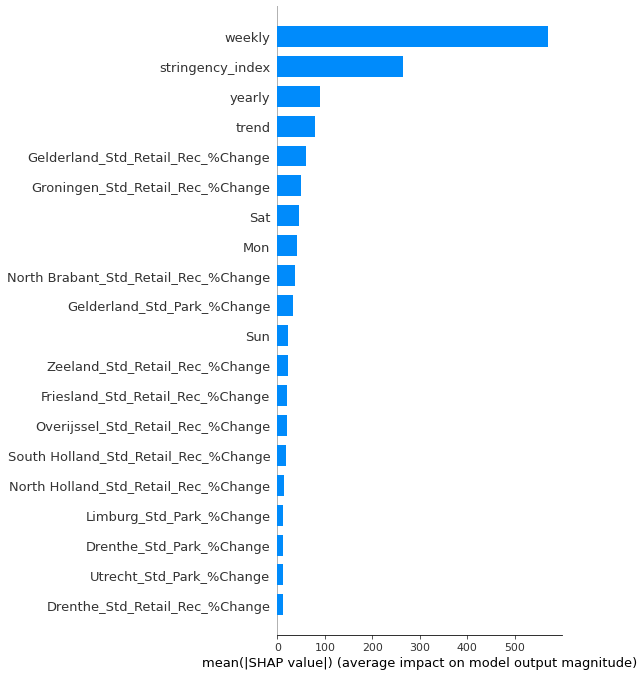

In [343]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_type='bar')

# **Phase 6: Statistical Analysis**

# Prediction Outcome in Graph

This section gives you a line plot graph of the forecasting that forecasters made using Python. You can review the line of the periods and make sure we don't have oddly wrong values. Forecasters can also adjust the values based on the logical decision making.

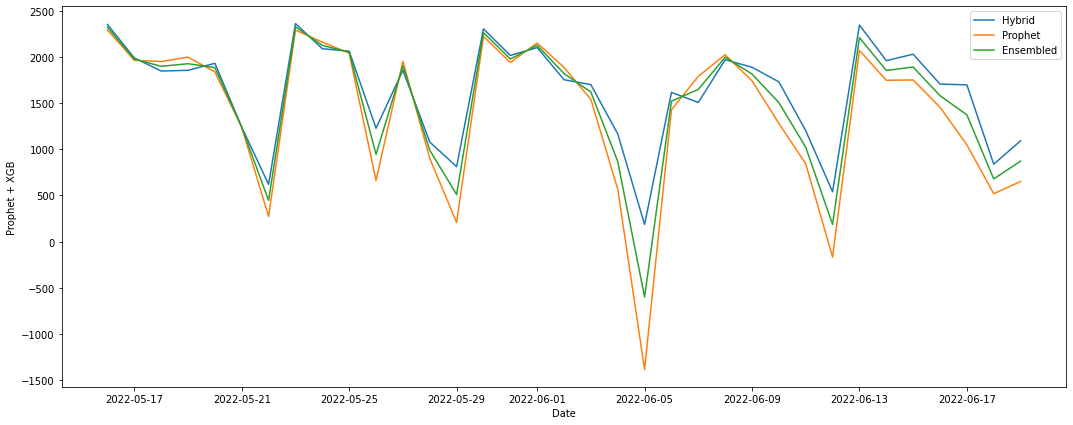

In [344]:
plt.figure(figsize=(18, 7))
sns.lineplot(x= 'Date', y='Prophet + XGB', data= ensembled2, palette = colors, label = 'Hybrid')
sns.lineplot(x= 'Date', y='Prophet', data= ensembled2, palette = colors, label = 'Prophet')
sns.lineplot(x= 'Date', y='Ensembled', data= ensembled2, palette = colors, label = 'Ensembled')

# Correlation with the Customer Demand

In [345]:
# take std values of the google community mobility report
cols_GM = ['retail_and_recreation_percent_change_from_baseline',
           'parks_percent_change_from_baseline'
           ]
df_GM = GM_region_1.groupby('Date', as_index=False, sort=True)[cols_GM].std()
df_GM.set_index('Date', inplace=True)
df_GM = df_GM.asfreq("D")

df_selectfeatures = [all, df_GM
       ] # do not include CCI as it is difficult to forecast the value
# nan_value = 0

df_selectfeatures = pd.concat(df_selectfeatures, join='outer', axis=1)
df_selectfeatures = df_selectfeatures.reindex(new_date_range)

df_selectfeatures = df_selectfeatures.rename(columns = {'TG' : "Ave Temp", 
                                                        'DDVEC': 'Wind Direction', 
                                                        'FHVEC': 'Vector Ave Wind Speed',
                                                        'FG': 'Daily Ave Wind Speed',
                                                        'FXX': 'Highest Wind Gust', 
                                                        'TN': 'Min Temp', 
                                                        'TX':"Max Temp", 
                                                        'SQ':'Sun Duration',
                                                        'NG':'Cloud',
                                                        'RH':'Sun Precipitation',
                                                        'retail_and_recreation_percent_change_from_baseline':'Google Retail Movement Change',
                                                        'parks_percent_change_from_baseline':'Google Park Movement Change'
                                                        })


In [346]:
# select features to display in the correlation with y
df_selectfeatures = df_selectfeatures[['Demand(y)', 
 

"Ave Temp", 
'Daily Ave Wind Speed',
"Max Temp", 
'Sun Duration','Cloud',
'stringency_index', 'new_cases_smoothed', 'new_deaths_smoothed',
 'Google Retail Movement Change',
 'Google Park Movement Change',
]]

# normalize the data
scaler = MinMaxScaler()
# transform data
scaled = scaler.fit_transform(df_selectfeatures)
x_scaled = pd.DataFrame(scaled)
df_scaled = pd.DataFrame(x_scaled)
df_scaled.columns = df_selectfeatures.columns
df_scaled.index = df_selectfeatures.index
#df_scaled = df_scaled.reset_index().rename(columns={'index': 'Date'})
df_scaled.head(3)

,Demand(y),Ave Temp,Daily Ave Wind Speed,Max Temp,Sun Duration,...,stringency_index,new_cases_smoothed,new_deaths_smoothed,Google Retail Movement Change,Google Park Movement Change
2021-01-01,0.000000,0.271647,0.134884,0.273775,0.114379,...,0.941083,0.063880,0.806490,0.012915,0.107889
2021-01-02,0.471652,0.293718,0.079070,0.240634,0.006536,...,0.941083,0.061958,0.792964,0.118100,0.083340
2021-01-03,0.269675,0.297114,0.320930,0.230548,0.006536,...,0.941083,0.060982,0.818672,0.215306,0.053548


**(1) Adjust dates that you would like to see the correlation** (*only in the red part)\
You can only review the correlation with the available data. So you can't set future values when you enter the date range for the correlation.

In [347]:
minmaxcorr = pd.date_range(start="2022-04-01", end="2022-04-30", freq="D")
df_scaled_corr = df_scaled.reindex(minmaxcorr)

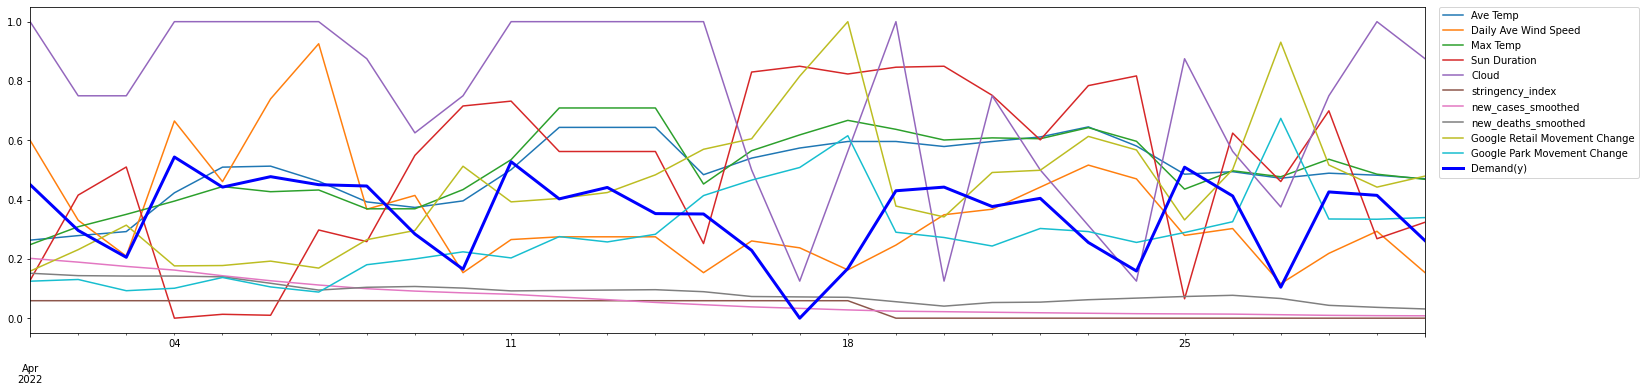

In [348]:
df_scaled_corr.iloc[:,1:].plot(figsize = (25, 6), legend = True)
df_scaled_corr['Demand(y)'].plot(figsize = (25, 6), color = 'blue', linewidth = 3, legend = True)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

**(2) Correlation of selected features. The correlation value reflects what you see in the graph.**

In [349]:
df_scaled_corr.corr()

,Demand(y),Ave Temp,Daily Ave Wind Speed,Max Temp,Sun Duration,...,stringency_index,new_cases_smoothed,new_deaths_smoothed,Google Retail Movement Change,Google Park Movement Change
Demand(y),1.000000,-0.020067,0.434913,-0.146898,-0.490926,...,-0.012264,0.227532,0.167061,-0.716912,-0.573379
Ave Temp,-0.020067,1.000000,-0.106672,0.950155,0.468958,...,-0.313260,-0.688918,-0.595417,0.446395,0.412309
Daily Ave Wind Speed,0.434913,-0.106672,1.000000,-0.278976,-0.423894,...,0.167735,0.448636,0.367800,-0.600941,-0.626766
Max Temp,-0.146898,0.950155,-0.278976,1.000000,0.645967,...,-0.254047,-0.667870,-0.586046,0.536754,0.465767
Sun Duration,-0.490926,0.468958,-0.423894,0.645967,1.000000,...,-0.251835,-0.527571,-0.519720,0.591800,0.437664
Cloud,0.647649,-0.233643,0.161628,-0.270273,-0.618632,...,0.382369,0.430348,0.400383,-0.567195,-0.467744
stringency_index,-0.012264,-0.313260,0.167735,-0.254047,-0.251835,...,1.000000,0.705327,0.758770,-0.254890,-0.289613
new_cases_smoothed,0.227532,-0.688918,0.448636,-0.667870,-0.527571,...,0.705327,1.000000,0.942365,-0.666491,-0.696091
new_deaths_smoothed,0.167061,-0.595417,0.367800,-0.586046,-0.519720,...,0.758770,0.942365,1.000000,-0.552678,-0.594496
Google Retail Movement Change,-0.716912,0.446395,-0.600941,0.536754,0.591800,...,-0.254890,-0.666491,-0.552678,1.000000,0.928161


**(3) If you want to review some specific date range within the graph, you can change the dates below.**

In [350]:
df_selectfeatures['2022-04-25':'2022-04-30']

,Demand(y),Ave Temp,Daily Ave Wind Speed,Max Temp,Sun Duration,...,stringency_index,new_cases_smoothed,new_deaths_smoothed,Google Retail Movement Change,Google Park Movement Change
2022-04-25,2730.0,88.0,43.5,113.0,10.0,...,19.44,2388.714,9.143,16.527223,62.351482
2022-04-26,2210.0,90.5,46.0,134.5,95.5,...,19.44,2296.857,9.571,21.521663,67.970151
2022-04-27,560.0,84.0,26.0,127.5,70.5,...,19.44,2044.714,8.429,34.134851,121.736005
2022-04-28,2283.0,89.0,37.0,148.0,107.0,...,19.44,1789.286,6.000,21.967174,69.393344
2022-04-29,2221.0,87.0,45.0,130.5,41.0,...,19.44,1654.857,5.286,19.776685,69.262952
2022-04-30,1401.0,83.5,30.0,124.5,49.5,...,19.44,1590.714,4.714,20.872181,70.120930
